# MULTIVIEW CLUSTERING

## Workspace Setup

### Packages

In [1]:
from   sklearn.experimental    import enable_iterative_imputer
from   tqdm                    import tqdm
import copy                    as     cp
import jupyterthemes           as     jt
import matplotlib              as     mpl
import matplotlib.pyplot       as     plt
import matplotlib_venn         as     mpv
import mvlearn.cluster         as     mvc
import numpy                   as     np
import pandas                  as     pd
import scipy.cluster.hierarchy as     sch
import scipy.io                as     spi
import scipy.spatial.distance  as     ssd
import scipy.stats             as     sps
import sklearn.cluster         as     skc
import sklearn.decomposition   as     skd
import sklearn.impute          as     ski
import sklearn.manifold        as     skma
import sklearn.metrics         as     skme
import sklearn.neighbors       as     skn
import sklearn.preprocessing   as     skp
import sklearn.ensemble        as     ske
import warnings

### Global Variables

In [2]:
# ignore minor warnings
warnings.filterwarnings("ignore")

# use jupytertheme for plots
jt.jtplot.style()

# set font for plots
mpl.rcParams.update({'font.size':6})

# set global path
main_dir = '/cluster/work/borgw/SPSS/MultiOmicsAnalysis/'

# clustering
args = {}
args['kmeans']   = {'n_clusters':3}
args['dbscan']   = {'eps':1.5,\
                    'min_samples':5}
args['spectral'] = {'n_clusters':3,\
                    'affinity':'rbf',\
                    'gamma':1.,\
                    'assign_labels':'discretize'}

### Functions

In [3]:
def fisher_pvalues(dat_df,test_cs,c,l):
    
    p_df = pd.DataFrame(index=test_cs,columns=['p_value'])
    
    for i in p_df.index:
        
        con_tab = np.empty((2,2))
        C = dat_df[c] == 1
        V = dat_df[i] == 1
        con_tab[0,0] = dat_df[C&V].shape[0]
        con_tab[0,1] = dat_df[C&~V].shape[0]
        con_tab[1,0] = dat_df[~C&V].shape[0]
        con_tab[1,1] = dat_df[~C&~V].shape[0]
        
        o,pv = sps.fisher_exact(con_tab)
        p_df.loc[i,'p_value'] = pv
        
    p_df = p_df.sort_values('p_value')
    p_df = p_df[p_df.p_value<l/p_df.shape[0]]
    
    return p_df

def protein_f_association(bims,label,test_cs,l,ttype):

    bimdat_df = pd.DataFrame(index=bims,columns=test_cs)

    for p in bims:

        c         = '%sbim%s_cluster' % (p,label)
        bim_df    = imp_df.copy(deep=True)
        cols      = [c for c in bim_df.columns if c in test_cs]+[p]
        bim_df    = bim_df[cols]
        bim_df[c] = 0
        
        if label=='proteome':
             bim_df.loc[(bim_df[p]<=bims[p]).T.values[0],c] = 1
        else:
            bim_df.loc[bim_df[p]<=bims[p],c] = 1
        
        bim_df = bim_df.drop(p,axis=1)

        if ttype=='f-test':
        
            f_df,null_df = f_pvalues(bim_df,'%sbim%s' % (p,label),l)
            f_df         = f_df[f_df.p_value==f_df.p_value.min()]
        
        elif ttype=='fisher':
            
            f_df = fisher_pvalues(bim_df,test_cs,c,l)

        bimdat_df.loc[p,f_df.index] = 1

    bimdat_df = bimdat_df.fillna(0)

    bimdat_pdf = bimdat_df.sum(axis=0).sort_values(ascending=False)
    bimdat_bdf = bimdat_df.sum(axis=1).sort_values(ascending=True)
    bimdat_df = bimdat_df.loc[bimdat_bdf.index,bimdat_pdf.index]

    bimdat_fig = plt.figure(figsize=(16,9))
    ax = bimdat_fig.add_subplot(111)
    ax.pcolor(bimdat_df)
    ax.set_yticks(np.arange(bimdat_df.shape[0])+.5)
    ax.set_yticklabels(bimdat_df.index)
    ax.set_xticks(np.arange(bimdat_df.shape[1])+.5)
    if label=='proteome':
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(bimdat_df.columns,rotation=45,ha='right')
    ax.grid('lightgray')
    plt.close()
    
    return bimdat_fig,bimdat_df

def hierarchical_cluster(dat_df,p):
    
    X = dat_df
    D = ssd.pdist(X)
    Z = sch.linkage(D,'ward')
    
    clu_df           = dat_df.copy(deep=True)
    clu_df['hieclu'] = sch.fcluster(Z,p,'maxclust')-1

    fig = plt.figure(figsize=(24,9))
    ax  = fig.add_subplot(111)
    ax.grid()
    sch.dendrogram(Z,
                   labels=dat_df.index,
                   truncate_mode='lastp',
                   p=p,
                   ax=ax,
                   leaf_rotation=45)
    plt.close()
    
    return fig,clu_df

def fstat_fig(dat_df,f_df,label):

    col = '%s_cluster' % label
    kw  = {'density':True,'alpha':.667}
    
    fig = plt.figure(figsize=(40,9))

    for i,v in enumerate(f_df.index[:10]):

        bs = np.linspace(int(dat_df[v].min()),int(dat_df[v].max()),25)
        ax = fig.add_subplot(2,5,i+1)

        for c in [d for d in dat_df[col].unique() if d!=-1]:
            m1 = np.round(dat_df.loc[dat_df[col]==c,v].mean(),1)
            m2 = np.round(dat_df.loc[dat_df[col]==c,v].median(),1)
            n  = np.round(dat_df.loc[dat_df[col]==c,v].shape[0],1)
            ax.hist(dat_df.loc[dat_df[col]==c,v],bins=bs,**kw,\
                    label=r'$n$=%s, $\mu$=%s, $m$=%s' % (n,m1,m2))

        ax.set_title(v)
        ax.legend()

    plt.close()
    
    return fig

def f_stats(df,c):
    
    k = len(df.loc[df[c]!=-1,c].unique())
    
    if k==1:
        print('no clusters')
    elif k==2:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        f,p = sps.f_oneway(c0,c1)
    elif k==3:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        f,p = sps.f_oneway(c0,c1,c2)
    elif k==4:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3)
    elif k==5:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4)
    elif k==6:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5)
    elif k==7:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6)
    elif k==8:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7)
    elif k==9:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8)
    elif k==10:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9)
    elif k==11:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10)
    elif k==12:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11)
    elif k==13:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12)
    elif k==14:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13)
    elif k==15:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14)
    elif k==16:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15)
    elif k==17:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        c16 = df.loc[df[c]==16,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16)
    elif k==18:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        c16 = df.loc[df[c]==16,:].values
        c17 = df.loc[df[c]==17,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17)
    elif k==19:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        c16 = df.loc[df[c]==16,:].values
        c17 = df.loc[df[c]==17,:].values
        c18 = df.loc[df[c]==18,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18)
    elif k==20:
        c0 = df.loc[df[c]==0,:].values
        c1 = df.loc[df[c]==1,:].values
        c2 = df.loc[df[c]==2,:].values
        c3 = df.loc[df[c]==3,:].values
        c4 = df.loc[df[c]==4,:].values
        c5 = df.loc[df[c]==5,:].values
        c6 = df.loc[df[c]==6,:].values
        c7 = df.loc[df[c]==7,:].values
        c8 = df.loc[df[c]==8,:].values
        c9 = df.loc[df[c]==9,:].values
        c10 = df.loc[df[c]==10,:].values
        c11 = df.loc[df[c]==11,:].values
        c12 = df.loc[df[c]==12,:].values
        c13 = df.loc[df[c]==13,:].values
        c14 = df.loc[df[c]==14,:].values
        c15 = df.loc[df[c]==15,:].values
        c16 = df.loc[df[c]==16,:].values
        c17 = df.loc[df[c]==17,:].values
        c18 = df.loc[df[c]==18,:].values
        c19 = df.loc[df[c]==19,:].values
        f,p = sps.f_oneway(c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19)
        
    fs_df = pd.DataFrame(f,index=df.columns,columns=['f_stat'])
    fs_df = fs_df.drop(c,axis=0)
    fs_df = fs_df.sort_values('f_stat',ascending=False)
    
    return fs_df

def assign_clusters(dat_df,clu_df,label,ccol):
    
    col = '%s_cluster' % label
    
    if col not in dat_df.columns:

        sv_df = pd.concat([dat_df,clu_df[ccol]],axis=1)
        c_dct = {}
        c_dct[ccol] = col

        for c in clu_df.columns:
            if 'ts' in c:
                c_dct[c] = '%s_%s' % (label,c)

        sv_df = sv_df.rename(columns=c_dct)
        
    else:
        
        sv_df = dat_df
    
    return sv_df

def ortho_project(dat_df,sub_df):
    
    ort_df = dat_df.copy(deep=True)
    
    for c in sub_df.columns:
        
        prj_df = np.outer(np.dot(sub_df[c],dat_df)/np.dot(sub_df[c],sub_df[c]),sub_df[c]).T
        ort_df = ort_df-prj_df
    
    return ort_df

def projection(dat_df,sub_df):
    
    prj_df = np.matmul(dat_df,sub_df.T)
    prj_df = prj_df.rename(columns={0:'p0',1:'p1',2:'p2'})
    
    return prj_df
 
def f_pvalues(dat_df,c,l):
    
    f0 = 'ConsensusClustering/data/%s_H0_fstats_%d.csv' % (c,int(100*l))
    f1 = 'ConsensusClustering/data/%s_fstats_%d.csv' % (c,int(100*l))
    
    try:
        
        f_df    = pd.read_csv('%s%s' % (main_dir,f1), index_col=0)
        null_df = pd.read_csv('%s%s' % (main_dir,f0), index_col=0)
        
    except:
    
        c       = '%s_cluster' % c
        cols    = [col for col in dat_df.columns if col!=c]
        n       = int(np.ceil(len(cols)/l-1))
        f_df    = pd.DataFrame(index=cols,columns=['p_value'])
        f_df    = pd.concat([f_df,f_stats(dat_df,c)],join='outer',axis=1)

        null_df = pd.DataFrame(index=cols)

        for p in tqdm(range(n-1)):

            perm_df    = dat_df.copy()
            perm_df[c] = np.random.permutation(perm_df[c])
            null_df    = pd.concat([null_df,f_stats(perm_df,c)],\
                                   join='outer',axis=1)
            null_df    = null_df.rename(columns={'f_stat':p+1})

        for i in f_df.index:

            f   = f_df.loc[i,'f_stat']
            fs  = null_df.loc[i,:].values
            fs  = np.append(fs,f)
            pv  = fs[fs>=f].shape[0]/n
            f_df.loc[i,'p_value'] = pv

        f_df = f_df.sort_values(['p_value','f_stat'],ascending=[True,False])
        f_df = f_df.dropna()
        f_df = f_df[f_df.p_value>=l/len(cols)]
        f_df = np.round(f_df,6)
        
        f_df.to_csv('%s%s' % (main_dir,f1))
        null_df.to_csv('%s%s' % (main_dir,f0))
        
    return f_df,null_df

def cluster(dat_df,algo):
    
    if   algo=='kmeans':
        clu = skc.KMeans(**args[algo]).fit(dat_df)
    elif algo=='dbscan':
        clu = skc.DBSCAN(**args[algo]).fit(dat_df)
    elif algo=='spectral':
        clu = skc.SpectralClustering(**args[algo]).fit(dat_df)
    
    lab_df= pd.DataFrame(clu.labels_,columns=[algo],index=dat_df.index)
    
    return lab_df

def pca_var(dat_df,ev,label):

    n      = dat_df.shape[1]
    pca    = skd.PCA(n_components=n)
    pca_ft = pca.fit(dat_df)
    pca_ev = pca_ft.explained_variance_ratio_
    pca_cv = np.array([sum(pca_ev[:i]) for i in range(1,n+1)])
    pca_n  = pca_cv[pca_cv<=ev].shape[0]+1
    pca_df = pd.DataFrame(pca.fit_transform(dat_df),\
                columns=['%spc_%d' % (label,i+1) for i in range(n)],\
                index = dat_df.index)
    pca_df = pca_df[pca_df.columns[:pca_n]]
    
    return pca_df

def tsne(dat_df,pars,states):

    pars0 = {}
    pars0['learning_rate']      = 'auto'
    pars0['init']               = 'random'
    pars0['method']             = 'exact'

    pars_df = pd.DataFrame(index=states,columns=['kl_div'])

    for r in tqdm(states):
        tsne = skma.TSNE(random_state=r,**pars0,**pars).fit(dat_df)
        pars_df.loc[r,'kl_div'] = tsne.kl_divergence_

    state   = pars_df.index[pars_df.kl_div==pars_df.kl_div.min()][0]
    tsne    = skma.TSNE(random_state=state,**pars0,**pars)\
                  .fit_transform(dat_df)
    cols    = ['ts%d' % d for d in range(1,pars['n_components']+1)]
    tsne_df = pd.DataFrame(tsne,index=dat_df.index,columns=cols)
    
    return tsne_df,state

def cluster_optimization(dat_df,n_states,n_comps,epsilons,min_samples,label):
    
    f = 'ConsensusClustering/data/%s_cluster_optimization_%d.csv' % (label,n_states)
    
    try:
        
        df = pd.read_csv('%s%s' % (main_dir,f), index_col=0)
        
    except:
    
        cs = ['dim','state','epsilon','n_mins','n_clusters','silhouette']
        df = pd.DataFrame(index=range(len(n_comps)*len(epss)),columns=cs)

        i = 0
        for n_comp in n_comps:

            # t-SNE
            tsne_pars = {'perplexity':30.,'n_components':n_comp}
            ts,state  = tsne(dat_df,tsne_pars,states=range(n_states))

            for eps in epss:

                for mins in minss:

                    # DBSCAN
                    args['dbscan']   = {'eps':eps,'min_samples':mins}
                    cdf = cluster(ts,'dbscan')
                    nc  = len(cdf.loc[cdf.dbscan!=-1,'dbscan'].unique())
                    df.loc[i,'dim']        = n_comp
                    df.loc[i,'state']      = state
                    df.loc[i,'epsilon']    = eps
                    df.loc[i,'n_mins']     = mins
                    df.loc[i,'n_clusters'] = nc

                    # Silhouette
                    if nc>1:
                        sil_avg = skme.silhouette_score(ts,cdf.dbscan)
                        sil_avg = sil_avg*cdf[cdf.dbscan!=-1].shape[0]/cdf.shape[0]
                    else:
                        sil_avg = np.nan
                        
                    df.loc[i,'silhouette'] = sil_avg

                    i += 1

        NOTEMPTY = ~df.silhouette.isna()
        POSITIVE = df.silhouette>0
        CLUSTER  = df.n_clusters<18
        df   = df[NOTEMPTY&POSITIVE&CLUSTER]
        df   = df.sort_values('silhouette',ascending=False)

        df.to_csv('%s%s' % (main_dir,f))
    
    return df

def cluster_fig(ts,clu_df,col):
    
    ts_fig = plt.figure(figsize=(32,9))
    ax1 = ts_fig.add_subplot(121)
    ax2 = ts_fig.add_subplot(122)
    
    pts  = ts[clu_df[col]>=0]
    pcdf = clu_df[clu_df[col]>=0]
    sils = skme.silhouette_samples(ts,clu_df[col])

    y_lower = 1

    for c in sorted(clu_df[col].unique()):

        cdf     = clu_df[clu_df[col]==c]
        csils   = sils[clu_df[col]==c]
        csils   = csils[csils>=0]
        csils.sort()
        nc      = csils.shape[0]
        y_upper = y_lower+nc

        if c!=-1:
            cl = mpl.cm.tab20(c)
            ax1.scatter(x=cdf.ts1,y=cdf.ts2,color=cl,label='cluster %d' % int(c+1))
            ax2.fill_betweenx(np.arange(y_lower,y_upper),0,csils,fc=cl)
        else:
            ax1.scatter(x=cdf.ts1,y=cdf.ts2,label='outliers',color='black')
            ax2.fill_betweenx(np.arange(y_lower,y_upper),0,csils,fc='black')

        y_lower = y_upper+1
        
    ax1.legend()
    ax1.set_xticks([])
    ax1.set_yticks([])
    try:
        avgs = skme.silhouette_score(pts,pcdf[col])
        ax2.axvline(x=avgs,color='w')
    except:
        None
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,y_upper+1])
    ax2.set_yticklabels([])

    plt.close()
    
    return ts_fig

def optimal_clusters(dat_df,opt_df):

    i     = opt_df.index[opt_df.silhouette==opt_df.silhouette.max()]
    dim   = opt_df.loc[i,'dim'].values[0]
    state = opt_df.loc[i,'state'].values[0]
    eps   = opt_df.loc[i,'epsilon'].values[0]
    mins  = opt_df.loc[i,'n_mins'].values[0]

    tsne_pars   = {'perplexity':30.,'n_components':dim}
    ts_df,state = tsne(dat_df,tsne_pars,states=[state])

    args['dbscan'] = {'eps':eps,'min_samples':mins}
    lab_df         = cluster(ts_df,'dbscan')
    clu_df         = pd.concat([lab_df,ts_df],axis=1)
    
    return ts_df,clu_df

## Data

### Loading and Merging

In [4]:
f = '/olinks/spss_mlcb_olink_episode.csv'
epi_df = pd.read_csv('%s%s' % (main_dir,f), index_col=0)

# filter for episodes in which serum sampling happened within 6 days after bc
PERIOD = (epi_df['sample.intv.d'] <=6) & (epi_df['sample.intv.d'] >=0)
epi_df = epi_df[PERIOD]

f = 'Data/spss_mlcb_day.csv'
bc_df = pd.read_csv('%s%s' % (main_dir,f), index_col=['sample.id'])
bc_df = bc_df[bc_df['redcap.event.name']=='day_sampling']
bc_df = bc_df[bc_df['data.available'] == 'yes']

f = 'ConsensusClustering/data/All Panels_2022_2020_raw_NPX_olink.csv'
npx_df = pd.read_csv('%s%s' % (main_dir,f), index_col=0)

raw_df = pd.concat([epi_df,bc_df,npx_df],join='inner',axis=1)
raw_df = raw_df.rename(columns={'age.at.bc.days':'age.at.bc'})
raw_df

,personal.id,episode.nr,study.site,eligibility,consent,consent.biob,age.at.bc,age.at.bc.months,age.at.bc.years,age.grp,...,Olink Target 96 Organ Damage(v.3311).82,Olink Target 96 Organ Damage(v.3311).83,Olink Target 96 Organ Damage(v.3311).84,Olink Target 96 Organ Damage(v.3311).85,Olink Target 96 Organ Damage(v.3311).86,Olink Target 96 Organ Damage(v.3311).87,Olink Target 96 Organ Damage(v.3311).88,Olink Target 96 Organ Damage(v.3311).89,Olink Target 96 Organ Damage(v.3311).90,Olink Target 96 Organ Damage(v.3311).91
BE-001,BE-001,0,Bern,eligible,yes,yes,2521,82,6,child.5y.9y,...,1.70159,3.48718,2.05995,3.76090,6.96531,4.18190,0.22963,2.45691,0.87458,1.74746
BE-003,BE-003,0,Bern,eligible,yes,yes,2285,75,6,child.5y.9y,...,3.59710,3.06095,2.04341,6.06249,6.69491,2.23101,1.37726,2.01789,1.63672,2.00566
BE-004,BE-004,0,Bern,eligible,yes,yes,717,23,1,child.1y.4y,...,1.73363,1.68708,2.19836,6.25993,5.32153,1.12803,1.08999,0.87993,0.04963,1.42964
BE-005,BE-005,0,Bern,eligible,yes,yes,4400,144,12,child.10y.16y,...,4.37900,3.18976,3.96052,7.78852,6.43559,2.50802,1.03539,0.41681,1.60899,2.15542
BE-007,BE-007,0,Bern,eligible,yes,yes,89,2,0,child.less12mt,...,3.08916,1.98271,4.14826,7.28065,7.33051,2.05212,1.72586,1.42252,0.78154,1.53606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,ZH-254,0,Zurich,eligible,yes,yes,41,1,0,child.less12mt,...,5.06552,2.87701,3.85969,10.63042,7.58074,1.53331,1.24035,1.68320,4.14710,2.54191
ZH-255,ZH-255,0,Zurich,eligible,yes,yes,12,0,0,neo.term,...,6.42122,2.89101,5.20275,10.70967,6.99078,3.31375,0.66809,1.16686,3.34361,3.40926
ZH-257,ZH-257,0,Zurich,eligible,yes,yes,360,11,0,child.less12mt,...,3.72867,2.44134,3.89944,9.87816,6.65984,2.61212,3.34854,0.92167,2.80111,1.77911
ZH-258,ZH-258,0,Zurich,eligible,yes,yes,57,1,0,child.less12mt,...,2.96162,2.31719,6.42890,6.05447,7.64716,1.46705,3.20317,1.93248,1.74769,1.80203


### Mapping to UniProt IDs

In [5]:
f = '/cluster/work/borgw/SPSS/o-link/20191053_Giannoni_NPX.csv'

map_df   = pd.read_csv('%s' % f)
map_df   = map_df.set_index('Uniprot ID',drop=True)
map_df   = map_df.drop(['Unnamed: 369','Unnamed: 370','Unnamed: 371',\
                        'Unnamed: 372','Unnamed: 373','Unnamed: 374',\
                        'Unnamed: 375','Unnamed: 376'],axis=1)

dict_df  = pd.DataFrame(map_df.loc['SG-053',:].T).reset_index()\
             .rename(columns={'index':'UniProtID'})
dict_df['SG-053'] = dict_df['SG-053'].astype(float)
dict2_df = pd.DataFrame(raw_df.loc['SG-053',:].T).reset_index()\
             .rename(columns={'index':'dat_col'})
dict_df  = dict_df.merge(dict2_df,on='SG-053',how='inner')

map_dict = pd.Series(dict_df.UniProtID.values,index=dict_df.dat_col)\
             .to_dict()

raw_df = raw_df.rename(columns=map_dict)

prots = [c for c in dict_df['UniProtID'].unique()]

## Preprocessing

### One-Hot Encoding

In [6]:
foc_df = pd.get_dummies(raw_df['focus.grp'], prefix='focus')
pat_df = pd.get_dummies(raw_df['pathogen.grp'], prefix='patho')
cah_df = pd.get_dummies(raw_df['cahai'], prefix='cahai')
cat_df = pd.get_dummies(raw_df['category'], prefix='cate')
eth_df = pd.get_dummies(raw_df['ethnicity'], prefix='eth')
ohe_df = pd.concat([raw_df,foc_df,pat_df,cah_df,cat_df,eth_df],\
                   join='outer',axis=1)
ohe_df = ohe_df.replace(['yes', 'no'], [1, 0])\
               .replace(['male', 'female'], [1, 0])
ohe_df

,personal.id,episode.nr,study.site,eligibility,consent,consent.biob,age.at.bc,age.at.bc.months,age.at.bc.years,age.grp,...,cahai_los.ca,cahai_los.hai,cate_comorbidity,cate_healthy,cate_neonate,eth_african,eth_asian,eth_caucasian,eth_jewish,eth_mixed
BE-001,BE-001,0,Bern,eligible,1,1,2521,82,6,child.5y.9y,...,0,0,1,0,0,0,0,1,0,0
BE-003,BE-003,0,Bern,eligible,1,1,2285,75,6,child.5y.9y,...,0,0,1,0,0,0,0,0,0,1
BE-004,BE-004,0,Bern,eligible,1,1,717,23,1,child.1y.4y,...,0,0,1,0,0,0,0,1,0,0
BE-005,BE-005,0,Bern,eligible,1,1,4400,144,12,child.10y.16y,...,0,0,0,1,0,0,0,1,0,0
BE-007,BE-007,0,Bern,eligible,1,1,89,2,0,child.less12mt,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,ZH-254,0,Zurich,eligible,1,1,41,1,0,child.less12mt,...,0,0,1,0,0,0,0,1,0,0
ZH-255,ZH-255,0,Zurich,eligible,1,1,12,0,0,neo.term,...,0,1,0,0,1,0,0,1,0,0
ZH-257,ZH-257,0,Zurich,eligible,1,1,360,11,0,child.less12mt,...,0,0,0,1,0,0,0,1,0,0
ZH-258,ZH-258,0,Zurich,eligible,1,1,57,1,0,child.less12mt,...,0,0,0,1,0,0,0,1,0,0


### Feature Selection

In [7]:
f = 'ConsensusClustering/Features.pkl'

sel_dc = pd.read_pickle('%s%s' % (main_dir,f))
sel_dc['proteome'] = prots
sel_ls = []

for f in sel_dc:
    print('\n%s\n' % f.upper())
    for i,ff in enumerate(sel_dc[f]):
        print('%d\t%s' % (i+1,ff))
        sel_ls += [ff]

sel_df = ohe_df[sel_ls].copy(deep=True)
sel_df


PHYSIO

1	temp.high
2	temp.low
3	rr.high
4	sato2.low
5	hr.high
6	cap.refill
7	sbp.low
8	map.low
9	gcs.low
10	fio2.high
11	wcc.high
12	wcc.low
13	anc.low
14	lymph.low
15	platelets.low
16	paco2.high
17	pao2.low
18	lactate.high
19	bili.high
20	crea.high
21	inr.high
22	alat.high

ORGANS

1	cons05.resp
2	cons05.cvs
3	cons05.cns
4	cons05.ren
5	cons05.hep
6	cons05.hem
7	cons05.score
8	pelod.resp
9	pelod.cvs
10	pelod.cns
11	pelod.ren
12	pelod.hem
13	pelod.score
14	psofa.resp
15	psofa.cvs
16	psofa.cns
17	psofa.ren
18	psofa.hep
19	psofa.hem
20	psofa.score

DEMOGRAPHICS

1	cate_neonate
2	eth_asian
3	eth_caucasian
4	eth_african
5	eth_jewish
6	sex
7	age.at.bc

CHRONIC_CONDITIONS

1	ccc.neuro
2	ccc.cardio
3	ccc.pulmo
4	ccc.uro
5	ccc.gastro
6	ccc.haemimmuno
7	ccc.metabol
8	ccc.malform
9	ccc.onco
10	ccc.neo
11	ccc.surg
12	ccc.techdep
13	ccc.transplant
14	cate_comorbidity
15	cate_healthy
16	ccc.summary

INFECTIONS

1	focus_abdominal
2	focus_clabsi
3	focus_cns
4	focus_earnosethroat
5	focus_endocarditis

,temp.high,temp.low,rr.high,sato2.low,hr.high,cap.refill,sbp.low,map.low,gcs.low,fio2.high,...,Q12913,Q7LG56,Q13308,P20472,Q9UHF1,Q0Z7S8,P98073,P01229,P53539,P27797
BE-001,38.4,36.5,45.0,97.0,140.0,3.0,71.0,45.0,13.0,NaN,...,1.70159,3.48718,2.05995,3.76090,6.96531,4.18190,0.22963,2.45691,0.87458,1.74746
BE-003,39.0,37.0,36.0,95.0,120.0,NaN,88.0,76.0,13.0,NaN,...,3.59710,3.06095,2.04341,6.06249,6.69491,2.23101,1.37726,2.01789,1.63672,2.00566
BE-004,39.8,39.8,40.0,94.0,156.0,NaN,93.0,93.0,NaN,NaN,...,1.73363,1.68708,2.19836,6.25993,5.32153,1.12803,1.08999,0.87993,0.04963,1.42964
BE-005,40.2,37.4,40.0,97.0,130.0,1.0,113.0,NaN,15.0,NaN,...,4.37900,3.18976,3.96052,7.78852,6.43559,2.50802,1.03539,0.41681,1.60899,2.15542
BE-007,38.5,38.0,59.0,97.0,156.0,NaN,NaN,NaN,NaN,NaN,...,3.08916,1.98271,4.14826,7.28065,7.33051,2.05212,1.72586,1.42252,0.78154,1.53606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,38.6,37.9,80.0,76.0,190.0,4.0,59.0,42.0,15.0,NaN,...,5.06552,2.87701,3.85969,10.63042,7.58074,1.53331,1.24035,1.68320,4.14710,2.54191
ZH-255,37.6,37.0,90.0,82.0,168.0,3.0,47.0,38.0,10.0,1.0,...,6.42122,2.89101,5.20275,10.70967,6.99078,3.31375,0.66809,1.16686,3.34361,3.40926
ZH-257,39.0,37.9,48.0,96.0,192.0,3.0,136.0,87.0,15.0,NaN,...,3.72867,2.44134,3.89944,9.87816,6.65984,2.61212,3.34854,0.92167,2.80111,1.77911
ZH-258,38.4,36.7,49.0,98.0,152.0,1.0,77.0,50.0,15.0,NaN,...,2.96162,2.31719,6.42890,6.05447,7.64716,1.46705,3.20317,1.93248,1.74769,1.80203


### Imputation

#### Physiological Variables

##### Missingness

###### Compute

In [8]:
phymis_df = sel_df[sel_dc['physio']].isnull().sum()\
                                    .sort_values(ascending=False)
phymis_df = phymis_df/sel_df.shape[0]

phymis_fg = plt.figure(figsize=(16,9))
ax1       = phymis_fg.add_subplot(111)
ax1.barh(y=range(phymis_df.shape[0]),\
         width=phymis_df.values,\
         ec='white',\
         linewidth=1,\
         tick_label=phymis_df.index.tolist())
ax1.set_xlim([0,1])
ax1.set_ylim([-.5,phymis_df.shape[0]-.5])
ax1.set_title('Missingness of Phyiological Variables Before Imputation')
ax1.set_xlabel('percent')
ax1.grid(False)
plt.close()

###### Figure

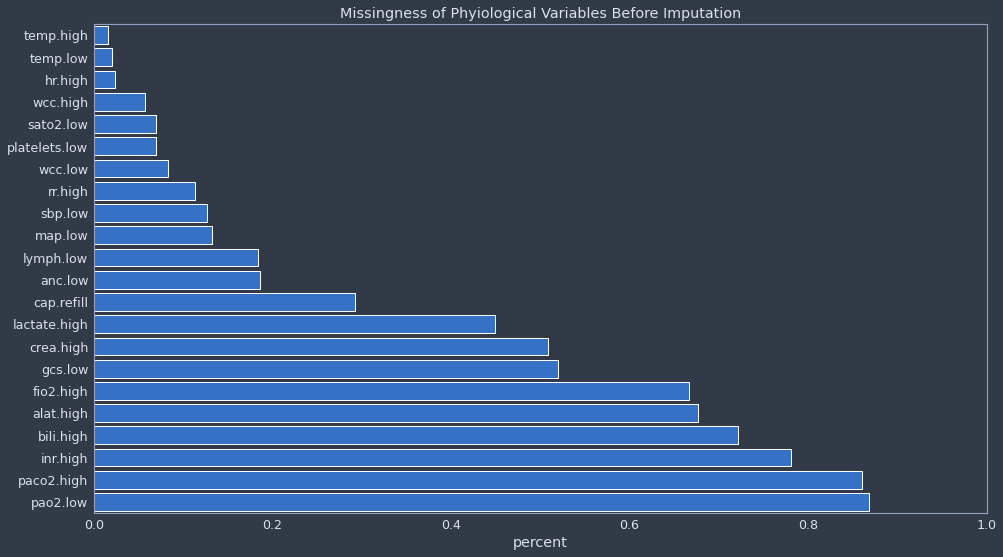

In [9]:
phymis_fg

##### Reference-Range Imputation

In [10]:
imp_df = sel_df.copy(deep=True)

# sex
M = imp_df.sex==1
F = imp_df.sex==0

# age ranges
DS_01   =  imp_df['age.at.bc']<=   1
DS_17   = (imp_df['age.at.bc'] >   1) & (imp_df['age.at.bc']<=   7)
DS_07   =  imp_df['age.at.bc']<=   7
DS_730  = (imp_df['age.at.bc'] >   7) & (imp_df['age.at.bc']<=  30)
MS_01   =  imp_df['age.at.bc']<=  30
MS_03   =  imp_df['age.at.bc']<=  91
MS_13   = (imp_df['age.at.bc'] >  30) & (imp_df['age.at.bc']<=  91)
MS_112  = (imp_df['age.at.bc'] >  30) & (imp_df['age.at.bc']<= 365)
MS_36   = (imp_df['age.at.bc'] >  91) & (imp_df['age.at.bc']<= 182)
MS_324  = (imp_df['age.at.bc'] >  91) & (imp_df['age.at.bc']<= 730)
MS_69   = (imp_df['age.at.bc'] > 182) & (imp_df['age.at.bc']<= 274)
MS_912  = (imp_df['age.at.bc'] > 274) & (imp_df['age.at.bc']<= 365)
MS_612  = (imp_df['age.at.bc'] > 182) & (imp_df['age.at.bc']<= 365)
MS_1218 = (imp_df['age.at.bc'] > 365) & (imp_df['age.at.bc']<= 547)
MS_1824 = (imp_df['age.at.bc'] > 547) & (imp_df['age.at.bc']<= 730)
YS_02   =  imp_df['age.at.bc']<= 730
YS_12   = (imp_df['age.at.bc'] > 365) & (imp_df['age.at.bc']<= 730)
YS_15   = (imp_df['age.at.bc'] > 365) & (imp_df['age.at.bc']<=1825)
YS_110  = (imp_df['age.at.bc'] > 365) & (imp_df['age.at.bc']<=3650)
YS_23   = (imp_df['age.at.bc'] > 730) & (imp_df['age.at.bc']<=1095)
YS_25   = (imp_df['age.at.bc'] > 730) & (imp_df['age.at.bc']<=1825)
YS_218  = (imp_df['age.at.bc'] > 730) & (imp_df['age.at.bc']<=6570)
YS_34   = (imp_df['age.at.bc'] >1095) & (imp_df['age.at.bc']<=1460)
YS_46   = (imp_df['age.at.bc'] >1460) & (imp_df['age.at.bc']<=2190)
YS_59   = (imp_df['age.at.bc'] >1825) & (imp_df['age.at.bc']<=3285)
YS_512  = (imp_df['age.at.bc'] >1825) & (imp_df['age.at.bc']<=4380)
YS_518  = (imp_df['age.at.bc'] >1825) & (imp_df['age.at.bc']<=6570)
YS_68   = (imp_df['age.at.bc'] >2190) & (imp_df['age.at.bc']<=2920)
YS_812  = (imp_df['age.at.bc'] >2920) & (imp_df['age.at.bc']<=4380)
YS_912  = (imp_df['age.at.bc'] >3285) & (imp_df['age.at.bc']<=4380)
YS_1018 = (imp_df['age.at.bc'] >3650) & (imp_df['age.at.bc']<=6570)
YS_1215 = (imp_df['age.at.bc'] >4380) & (imp_df['age.at.bc']<=5475)
YS_1216 = (imp_df['age.at.bc'] >4380) & (imp_df['age.at.bc']<=5840)
YS_1218 = (imp_df['age.at.bc'] >4380) & (imp_df['age.at.bc']<=6570)
YS_1518 = (imp_df['age.at.bc'] >5475) & (imp_df['age.at.bc']<=6570)
YS_1618 = (imp_df['age.at.bc'] >5840) & (imp_df['age.at.bc']<=6570)

imp_df.loc[M&MS_01,  'alat.high'] = imp_df.loc[M&MS_01,  'alat.high'].fillna(44.5)
imp_df.loc[M&MS_13,  'alat.high'] = imp_df.loc[M&MS_13,  'alat.high'].fillna(47.7)
imp_df.loc[M&MS_36,  'alat.high'] = imp_df.loc[M&MS_36,  'alat.high'].fillna(49.3)
imp_df.loc[M&MS_612, 'alat.high'] = imp_df.loc[M&MS_612, 'alat.high'].fillna(46.8)
imp_df.loc[M&MS_1218,'alat.high'] = imp_df.loc[M&MS_1218,'alat.high'].fillna(38.0)
imp_df.loc[M&MS_1824,'alat.high'] = imp_df.loc[M&MS_1824,'alat.high'].fillna(32.6)
imp_df.loc[M&YS_25,  'alat.high'] = imp_df.loc[M&YS_25,  'alat.high'].fillna(30.0)
imp_df.loc[M&YS_518, 'alat.high'] = imp_df.loc[M&YS_518, 'alat.high'].fillna(33.2)
imp_df.loc[F&MS_01,  'alat.high'] = imp_df.loc[F&MS_01,  'alat.high'].fillna(44.1)
imp_df.loc[F&MS_13,  'alat.high'] = imp_df.loc[F&MS_13,  'alat.high'].fillna(46.7)
imp_df.loc[F&MS_36,  'alat.high'] = imp_df.loc[F&MS_36,  'alat.high'].fillna(45.7)
imp_df.loc[F&MS_612, 'alat.high'] = imp_df.loc[F&MS_612, 'alat.high'].fillna(41.2)
imp_df.loc[F&MS_1218,'alat.high'] = imp_df.loc[F&MS_1218,'alat.high'].fillna(34.9)
imp_df.loc[F&MS_1824,'alat.high'] = imp_df.loc[F&MS_1824,'alat.high'].fillna(30.9)
imp_df.loc[F&YS_25,  'alat.high'] = imp_df.loc[F&YS_25,  'alat.high'].fillna(28.2)
imp_df.loc[F&YS_518, 'alat.high'] = imp_df.loc[F&YS_518, 'alat.high'].fillna(26.0)

imp_df.loc[MS_03,  'hr.high'] = imp_df.loc[MS_03,  'hr.high'].fillna(164)
imp_df.loc[MS_36,  'hr.high'] = imp_df.loc[MS_36,  'hr.high'].fillna(159)
imp_df.loc[MS_69,  'hr.high'] = imp_df.loc[MS_69,  'hr.high'].fillna(152)
imp_df.loc[MS_912, 'hr.high'] = imp_df.loc[MS_912, 'hr.high'].fillna(145)
imp_df.loc[MS_1218,'hr.high'] = imp_df.loc[MS_1218,'hr.high'].fillna(140)
imp_df.loc[MS_1824,'hr.high'] = imp_df.loc[MS_1824,'hr.high'].fillna(135)
imp_df.loc[YS_23,  'hr.high'] = imp_df.loc[YS_23,  'hr.high'].fillna(128)
imp_df.loc[YS_34,  'hr.high'] = imp_df.loc[YS_34,  'hr.high'].fillna(123)
imp_df.loc[YS_46,  'hr.high'] = imp_df.loc[YS_46,  'hr.high'].fillna(117)
imp_df.loc[YS_68,  'hr.high'] = imp_df.loc[YS_68,  'hr.high'].fillna(111)
imp_df.loc[YS_812, 'hr.high'] = imp_df.loc[YS_812, 'hr.high'].fillna(103)
imp_df.loc[YS_1215,'hr.high'] = imp_df.loc[YS_1215,'hr.high'].fillna( 96)
imp_df.loc[YS_1518,'hr.high'] = imp_df.loc[YS_1518,'hr.high'].fillna( 92)

imp_df['inr.high'] = imp_df['inr.high'].fillna(1.1)

imp_df['fio2.high'] = imp_df['fio2.high'].fillna(0.21)

imp_df.loc[MS_03, 'lactate.high'] = imp_df.loc[MS_03, 'lactate.high'].fillna(3.5)
imp_df.loc[MS_324,'lactate.high'] = imp_df.loc[MS_324,'lactate.high'].fillna(3.3)
imp_df.loc[YS_218,'lactate.high'] = imp_df.loc[YS_218,'lactate.high'].fillna(2.4)

imp_df['paco2.high'] = imp_df['paco2.high'].fillna(58.5)

imp_df.loc[MS_03,  'rr.high'] = imp_df.loc[MS_03,  'rr.high'].fillna(57)
imp_df.loc[MS_36,  'rr.high'] = imp_df.loc[MS_36,  'rr.high'].fillna(55)
imp_df.loc[MS_69,  'rr.high'] = imp_df.loc[MS_69,  'rr.high'].fillna(52)
imp_df.loc[MS_912, 'rr.high'] = imp_df.loc[MS_912, 'rr.high'].fillna(50)
imp_df.loc[MS_1218,'rr.high'] = imp_df.loc[MS_1218,'rr.high'].fillna(46)
imp_df.loc[MS_1824,'rr.high'] = imp_df.loc[MS_1824,'rr.high'].fillna(40)
imp_df.loc[YS_23,  'rr.high'] = imp_df.loc[YS_23,  'rr.high'].fillna(34)
imp_df.loc[YS_34,  'rr.high'] = imp_df.loc[YS_34,  'rr.high'].fillna(29)
imp_df.loc[YS_46,  'rr.high'] = imp_df.loc[YS_46,  'rr.high'].fillna(27)
imp_df.loc[YS_68,  'rr.high'] = imp_df.loc[YS_68,  'rr.high'].fillna(24)
imp_df.loc[YS_812, 'rr.high'] = imp_df.loc[YS_812, 'rr.high'].fillna(22)
imp_df.loc[YS_1215,'rr.high'] = imp_df.loc[YS_1215,'rr.high'].fillna(21)
imp_df.loc[YS_1518,'rr.high'] = imp_df.loc[YS_1518,'rr.high'].fillna(19)

imp_df.loc[MS_01,  'crea.high'] = imp_df.loc[MS_01,  'crea.high'].fillna(69)
imp_df.loc[MS_112, 'crea.high'] = imp_df.loc[MS_112, 'crea.high'].fillna(22)
imp_df.loc[YS_12,  'crea.high'] = imp_df.loc[YS_12,  'crea.high'].fillna(34)
imp_df.loc[YS_25,  'crea.high'] = imp_df.loc[YS_25,  'crea.high'].fillna(50)
imp_df.loc[YS_512, 'crea.high'] = imp_df.loc[YS_512, 'crea.high'].fillna(58)
imp_df.loc[YS_1218,'crea.high'] = imp_df.loc[YS_1218,'crea.high'].fillna(92)

imp_df['temp.high'] = imp_df['temp.high'].fillna(38.5)

imp_df.loc[M&YS_02,  'bili.high'] = imp_df.loc[M&YS_02,  'bili.high'].fillna(12)
imp_df.loc[M&YS_25,  'bili.high'] = imp_df.loc[M&YS_25,  'bili.high'].fillna(13)
imp_df.loc[M&YS_59,  'bili.high'] = imp_df.loc[M&YS_59,  'bili.high'].fillna(15)
imp_df.loc[M&YS_912, 'bili.high'] = imp_df.loc[M&YS_912, 'bili.high'].fillna(18)
imp_df.loc[M&YS_1216,'bili.high'] = imp_df.loc[M&YS_1216,'bili.high'].fillna(22)
imp_df.loc[M&YS_1618,'bili.high'] = imp_df.loc[M&YS_1618,'bili.high'].fillna(27)
imp_df.loc[F&YS_02,  'bili.high'] = imp_df.loc[F&YS_02,  'bili.high'].fillna(9)
imp_df.loc[F&YS_25,  'bili.high'] = imp_df.loc[F&YS_25,  'bili.high'].fillna(12)
imp_df.loc[F&YS_59,  'bili.high'] = imp_df.loc[F&YS_59,  'bili.high'].fillna(17)
imp_df.loc[F&YS_912, 'bili.high'] = imp_df.loc[F&YS_912, 'bili.high'].fillna(22)
imp_df.loc[F&YS_1216,'bili.high'] = imp_df.loc[F&YS_1216,'bili.high'].fillna(25)
imp_df.loc[F&YS_1618,'bili.high'] = imp_df.loc[F&YS_1618,'bili.high'].fillna(26)

imp_df.loc[DS_07,  'wcc.high'] = imp_df.loc[DS_07,  'wcc.high'].fillna(34.0)
imp_df.loc[DS_730, 'wcc.high'] = imp_df.loc[DS_730, 'wcc.high'].fillna(19.5)
imp_df.loc[MS_112, 'wcc.high'] = imp_df.loc[MS_112, 'wcc.high'].fillna(17.5)
imp_df.loc[YS_15,  'wcc.high'] = imp_df.loc[YS_15,  'wcc.high'].fillna(15.5)
imp_df.loc[YS_512, 'wcc.high'] = imp_df.loc[YS_512, 'wcc.high'].fillna(13.5)
imp_df.loc[YS_1218,'wcc.high'] = imp_df.loc[YS_1218,'wcc.high'].fillna(11.0)

imp_df['cap.refill'] = imp_df['cap.refill'].fillna(1)

imp_df.loc[DS_01,  'anc.low'] = imp_df.loc[DS_01,  'anc.low'].fillna(6.0)
imp_df.loc[DS_17,  'anc.low'] = imp_df.loc[DS_17,  'anc.low'].fillna(5.0)
imp_df.loc[DS_730, 'anc.low'] = imp_df.loc[DS_730, 'anc.low'].fillna(1.5)
imp_df.loc[MS_112, 'anc.low'] = imp_df.loc[MS_112, 'anc.low'].fillna(1.0)
imp_df.loc[YS_110, 'anc.low'] = imp_df.loc[YS_110, 'anc.low'].fillna(1.5)
imp_df.loc[YS_1018,'anc.low'] = imp_df.loc[YS_1018,'anc.low'].fillna(1.8)

imp_df['gcs.low'] = imp_df['gcs.low'].fillna(15)

imp_df['lymph.low'] = imp_df['lymph.low'].fillna(1)

imp_df.loc[MS_01,  'map.low'] = imp_df.loc[MS_01,  'map.low'].fillna(46)
imp_df.loc[MS_112, 'map.low'] = imp_df.loc[MS_112, 'map.low'].fillna(55)
imp_df.loc[YS_12,  'map.low'] = imp_df.loc[YS_12,  'map.low'].fillna(60)
imp_df.loc[YS_25,  'map.low'] = imp_df.loc[YS_25,  'map.low'].fillna(62)
imp_df.loc[YS_512, 'map.low'] = imp_df.loc[YS_512, 'map.low'].fillna(65)
imp_df.loc[YS_1218,'map.low'] = imp_df.loc[YS_1218,'map.low'].fillna(67)

imp_df['sato2.low'] = imp_df['sato2.low'].fillna(92)

imp_df['pao2.low'] = imp_df['pao2.low'].fillna(61)

imp_df['platelets.low'] = imp_df['platelets.low'].fillna(76.5)

imp_df.loc[DS_07,  'sbp.low'] = imp_df.loc[DS_07,  'sbp.low'].fillna(65)
imp_df.loc[DS_730, 'sbp.low'] = imp_df.loc[DS_730, 'sbp.low'].fillna(75)
imp_df.loc[MS_112, 'sbp.low'] = imp_df.loc[MS_112, 'sbp.low'].fillna(100)
imp_df.loc[YS_15,  'sbp.low'] = imp_df.loc[YS_15,  'sbp.low'].fillna(102)
imp_df.loc[YS_512, 'sbp.low'] = imp_df.loc[YS_512, 'sbp.low'].fillna(105)
imp_df.loc[YS_1218,'sbp.low'] = imp_df.loc[YS_1218,'sbp.low'].fillna(117)

imp_df['temp.low'] = imp_df['temp.low'].fillna(36.0)

imp_df.loc[MS_01,  'wcc.low'] = imp_df.loc[MS_01,  'wcc.low'].fillna(5.0)
imp_df.loc[MS_112, 'wcc.low'] = imp_df.loc[MS_112, 'wcc.low'].fillna(5.0)
imp_df.loc[YS_15,  'wcc.low'] = imp_df.loc[YS_15,  'wcc.low'].fillna(6.0)
imp_df.loc[YS_512, 'wcc.low'] = imp_df.loc[YS_512, 'wcc.low'].fillna(4.5)
imp_df.loc[YS_1218,'wcc.low'] = imp_df.loc[YS_1218,'wcc.low'].fillna(4.5)

#### Proteome

##### Missingness

###### Compute

In [11]:
promis_df = sel_df[sel_dc['proteome']].isnull().sum()\
                                      .sort_values(ascending=False)
promis_df = promis_df/sel_df.shape[0]
promis_df = promis_df[promis_df!=0]

promis_fg = plt.figure(figsize=(16,9))
ax1       = promis_fg.add_subplot(111)
ax1.barh(y=range(promis_df.shape[0]),\
         width=promis_df.values,\
         ec='white',\
         linewidth=1,\
         tick_label=promis_df.index.tolist())
ax1.set_xlim([0,1])
ax1.set_ylim([-.5,promis_df.shape[0]-.5])
ax1.set_title('Missingness of Proteins Before Imputation')
ax1.set_xlabel('percent')
ax1.grid(False)
plt.close()

###### Figure

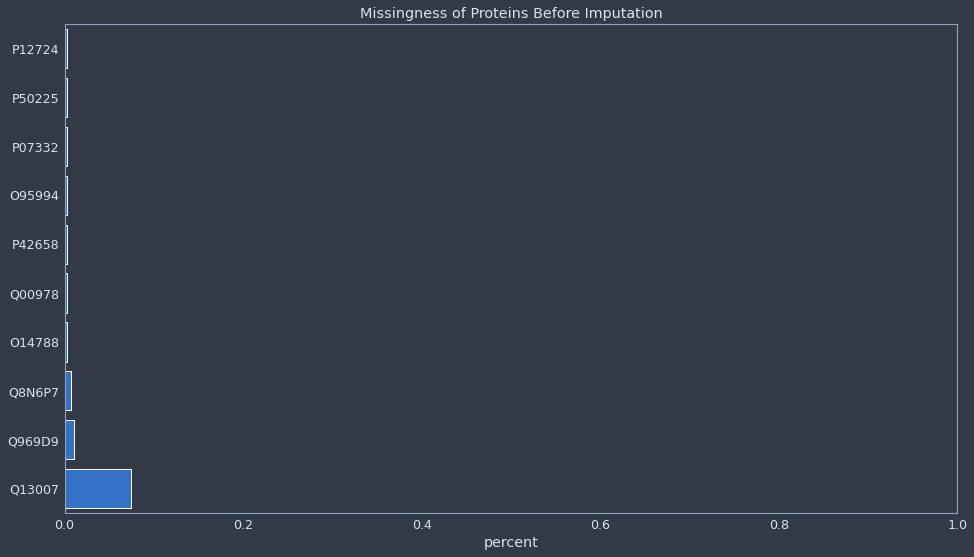

In [12]:
promis_fg

#####  Multiple Imputation by Chained Equations (MICE)

In [13]:
mice = ski.IterativeImputer(max_iter=100,\
                            initial_strategy='median',\
                            skip_complete=True,\
                            min_value=0,\
                            max_value=imp_df[sel_dc['proteome']].max().max())

imp_df[sel_dc['proteome']] =  mice.fit_transform(imp_df[sel_dc['proteome']])
imp_df[sel_dc['proteome']]

,Q96SB3,P16278,O75475,Q05516,Q9NWZ3,Q15661,P14317,Q9UHC6,Q6UXB4,Q00978,...,Q12913,Q7LG56,Q13308,P20472,Q9UHF1,Q0Z7S8,P98073,P01229,P53539,P27797
BE-001,2.189480,2.591750,4.848860,1.737870,1.645060,5.323420,4.700430,2.398600,4.477340,2.565510,...,1.70159,3.48718,2.05995,3.76090,6.96531,4.18190,0.22963,2.45691,0.87458,1.74746
BE-003,4.374040,2.980250,5.676970,4.644750,5.197660,4.755190,6.598710,2.275020,4.211850,4.689300,...,3.59710,3.06095,2.04341,6.06249,6.69491,2.23101,1.37726,2.01789,1.63672,2.00566
BE-004,3.064210,1.851580,2.073060,2.873600,1.803510,6.737260,4.180860,1.999300,2.599490,2.100520,...,1.73363,1.68708,2.19836,6.25993,5.32153,1.12803,1.08999,0.87993,0.04963,1.42964
BE-005,6.908315,0.920112,6.015381,4.953772,7.222683,6.940401,10.382117,4.347090,5.872441,4.092666,...,4.37900,3.18976,3.96052,7.78852,6.43559,2.50802,1.03539,0.41681,1.60899,2.15542
BE-007,3.088700,4.241990,4.357900,2.859930,2.193450,6.208380,5.462200,4.286340,4.010610,2.461800,...,3.08916,1.98271,4.14826,7.28065,7.33051,2.05212,1.72586,1.42252,0.78154,1.53606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,4.805850,5.013930,6.319910,5.300950,4.610000,6.068970,6.847390,3.783100,3.760460,5.079230,...,5.06552,2.87701,3.85969,10.63042,7.58074,1.53331,1.24035,1.68320,4.14710,2.54191
ZH-255,5.385860,4.295540,6.509910,5.139260,4.801040,6.559500,7.278640,5.505870,4.491950,5.028190,...,6.42122,2.89101,5.20275,10.70967,6.99078,3.31375,0.66809,1.16686,3.34361,3.40926
ZH-257,5.002694,2.358387,6.289317,6.673875,3.401441,7.141498,7.858672,7.740111,5.498104,5.801897,...,3.72867,2.44134,3.89944,9.87816,6.65984,2.61212,3.34854,0.92167,2.80111,1.77911
ZH-258,3.841330,3.329035,4.487176,1.960050,2.027405,7.127125,7.896770,8.531797,5.550231,2.815816,...,2.96162,2.31719,6.42890,6.05447,7.64716,1.46705,3.20317,1.93248,1.74769,1.80203


##### Binary Variables

In [14]:
imp_df.columns[imp_df.isna().any()]

Index(['ccc.neuro', 'ccc.cardio', 'ccc.pulmo', 'ccc.uro', 'ccc.gastro',
       'ccc.haemimmuno', 'ccc.metabol', 'ccc.malform', 'ccc.onco', 'ccc.neo',
       'ccc.surg', 'ccc.techdep', 'ccc.transplant', 'abx.change.pen',
       'abx.change.oxa', 'abx.change.pip', 'abx.change.cla', 'abx.change.cxm',
       'abx.change.cro', 'abx.change.fep', 'abx.change.mem', 'abx.change.amk',
       'abx.change.van', 'abx.change.cip', 'abx.change.lzd', 'abx.change.cli',
       'abx.change.mtz', 'abx.change.sxt', 'niv', 'iv', 'hfnc', 'ecls',
       'inotrope', 'crrt'],
      dtype='object')

In [15]:
imp_df = imp_df.fillna(0)

### PCA of Binary Variables

#### Confounders

In [16]:
pca0_cs = sel_dc['demographics']
pca0_cs = [c for c in pca0_cs if 'age' not in c]
pca0_df = pca_var(imp_df[pca0_cs],.95,'dem')
pca_df  = pd.concat([imp_df,pca0_df],join='inner',axis=1)

#### Contextual Variables

In [17]:
pca1_cs = sel_dc['chronic_conditions']+\
          ['niv','iv','hfnc','ecls','inotrope','crrt']
          #[c for c in sel_dc['organs'] if (('cons' in c) and ('score' not in c))]
pca1_df = pca_var(imp_df[pca1_cs],.95,'con')
pca_df  = pd.concat([imp_df,pca0_df,pca1_df],join='inner',axis=1)

#### Infection Variables

In [18]:
pca2_cs = sel_dc['infections']+sel_dc['pathogen']+sel_dc['treatment']
nos     = ['niv','iv','hfnc','ecls','inotrope','crrt']
pca2_cs = [c for c in pca2_cs if not any([n in c for n in nos])]
pca2_df = pca_var(imp_df[pca2_cs],.95,'inf')
pca_df  = pd.concat([imp_df,pca0_df,pca1_df,pca2_df],join='inner',axis=1)
pca_df

,temp.high,temp.low,rr.high,sato2.low,hr.high,cap.refill,sbp.low,map.low,gcs.low,fio2.high,...,infpc_22,infpc_23,infpc_24,infpc_25,infpc_26,infpc_27,infpc_28,infpc_29,infpc_30,infpc_31
BE-001,38.4,36.5,45.0,97.0,140.0,3.0,71.0,45.0,13.0,0.21,...,0.473268,-0.088749,0.048121,-0.118653,-0.217180,0.551535,0.380187,-0.120814,-0.097800,0.459311
BE-003,39.0,37.0,36.0,95.0,120.0,1.0,88.0,76.0,13.0,0.21,...,0.090804,0.072890,-0.175125,-0.151438,-0.097932,0.065396,-0.100803,-0.016855,-0.071142,-0.059128
BE-004,39.8,39.8,40.0,94.0,156.0,1.0,93.0,93.0,15.0,0.21,...,-0.214838,0.042017,-0.142699,-0.070053,-0.351335,0.229853,0.078046,0.246735,-0.236640,-0.134677
BE-005,40.2,37.4,40.0,97.0,130.0,1.0,113.0,67.0,15.0,0.21,...,0.165080,0.077960,0.115634,-0.040376,-0.062915,-0.254271,-0.081372,-0.066870,-0.210163,0.306584
BE-007,38.5,38.0,59.0,97.0,156.0,1.0,100.0,55.0,15.0,0.21,...,-0.158000,0.085244,-0.113380,-0.306229,-0.056817,0.145506,-0.126946,0.029240,0.084384,0.163887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,38.6,37.9,80.0,76.0,190.0,4.0,59.0,42.0,15.0,0.21,...,-0.014120,0.365675,0.036399,-0.292167,-0.055722,-0.294444,-0.411319,-0.143436,0.411485,0.006276
ZH-255,37.6,37.0,90.0,82.0,168.0,3.0,47.0,38.0,10.0,1.00,...,-0.067183,-0.010386,-0.018100,-0.005487,-0.008917,-0.031426,0.099409,-0.027725,0.038099,-0.022106
ZH-257,39.0,37.9,48.0,96.0,192.0,3.0,136.0,87.0,15.0,0.21,...,-0.223035,0.060825,-0.139964,0.690931,-0.485987,0.269812,-0.249111,-0.175648,0.201562,0.132961
ZH-258,38.4,36.7,49.0,98.0,152.0,1.0,77.0,50.0,15.0,0.21,...,-0.043187,-0.169295,-0.170401,-0.267444,-0.117871,0.104722,0.103962,0.078581,0.120574,0.013417


### Standardization

#### Original Distributions

##### Physiology

###### Compute

In [19]:
physio_cs  = [c for c in sel_dc['physio'] if 'fio2.high' not in c]#+\
             #[c for c in sel_dc['organs'] if 'cons' not in c]
physio_cs  = [c for c in physio_cs if c not in pca1_cs]

physdist_fg = plt.figure(figsize=(35,50))

for i,c in enumerate(physio_cs):

    ax = physdist_fg.add_subplot(10,4,i+1)
    ax.hist(sel_df[c],color='w',density=True,label='original',bins=15)
    ax.hist(pca_df[c],alpha=.75,density=True,label='imputed',bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)
    plt.legend()

plt.close()

###### Figure

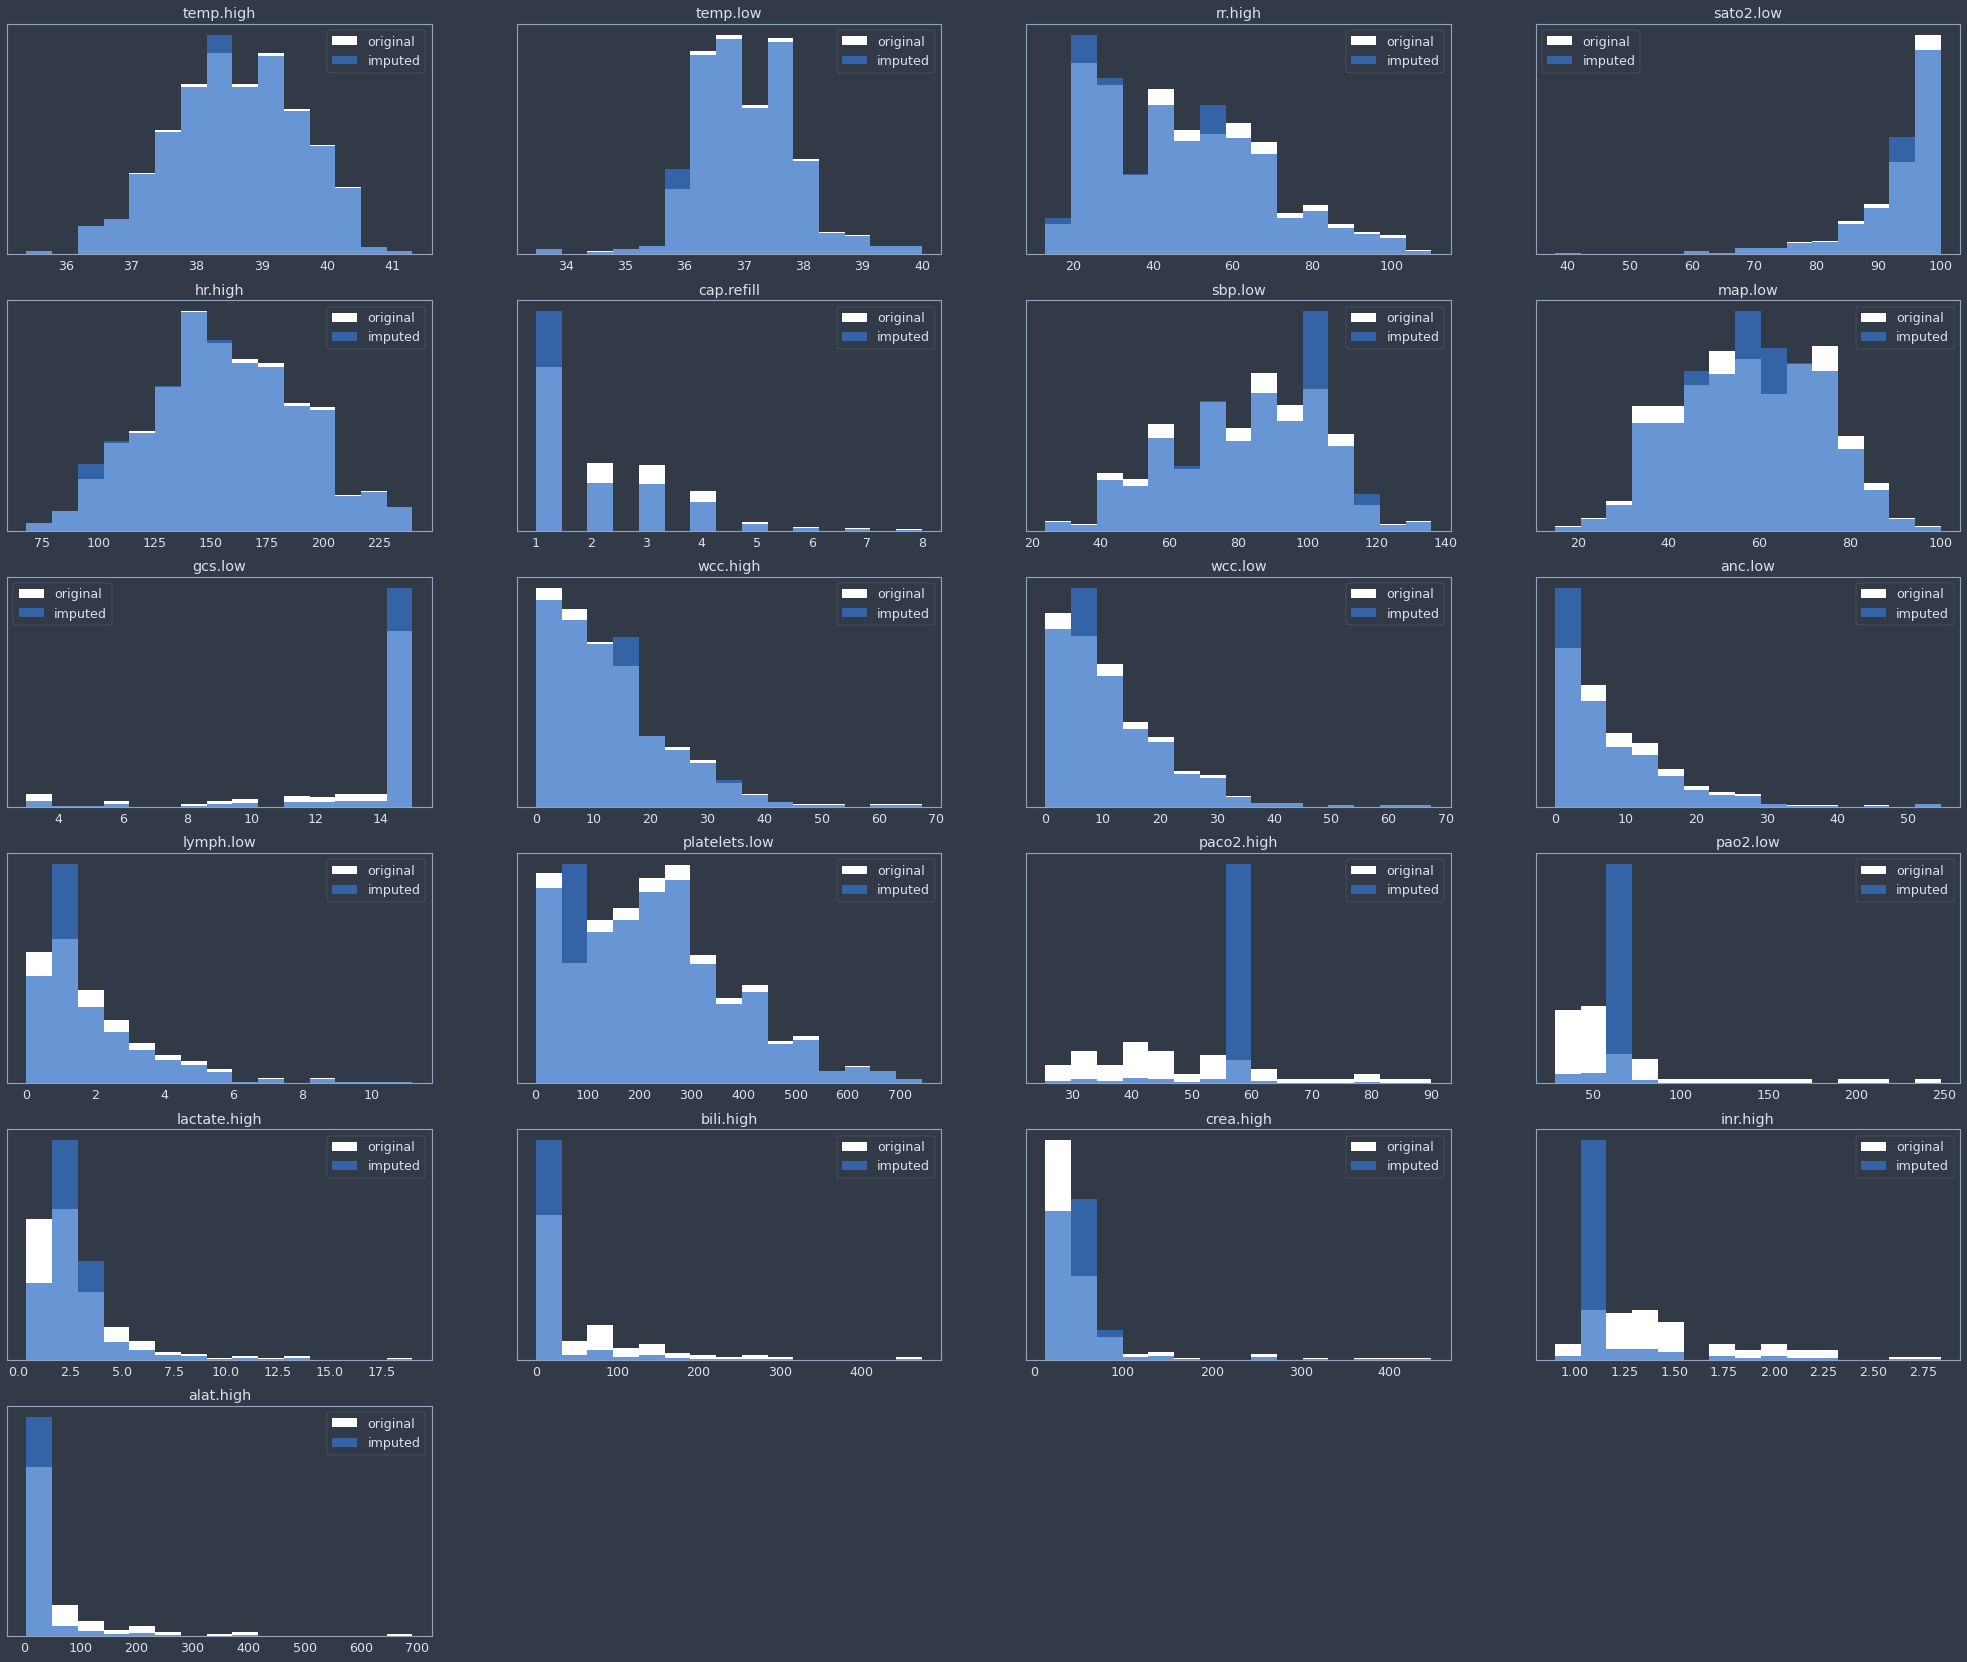

In [20]:
physdist_fg

##### Confounder PCs

###### Compute

In [21]:
dempc_cs = [c for c in pca_df.columns if 'dempc' in c]
dempc_fg = plt.figure(figsize=(35,25))

for i,c in enumerate(dempc_cs):

    ax = dempc_fg.add_subplot(5,4,i+1)
    ax.hist(pca_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

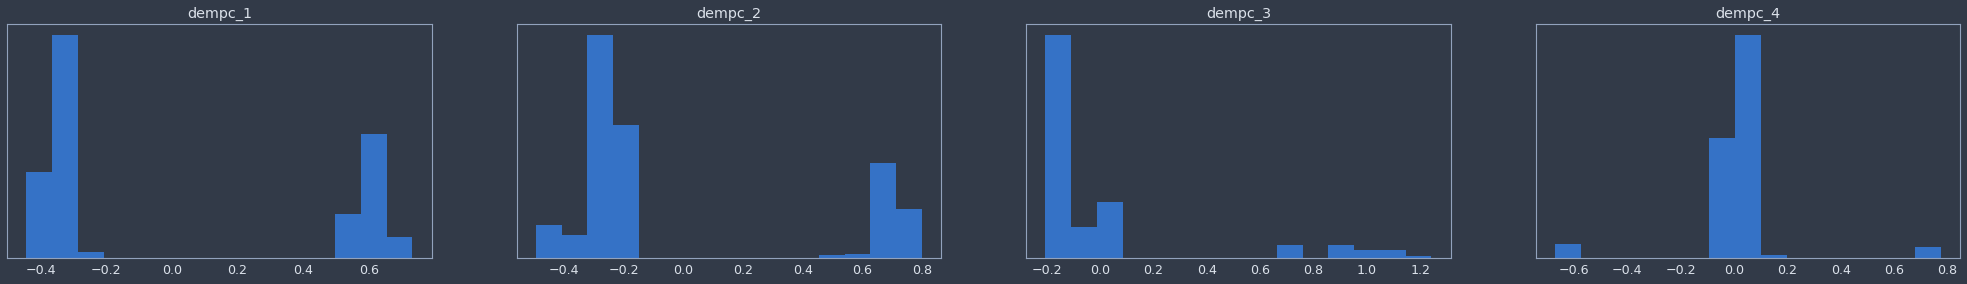

In [22]:
dempc_fg

##### Contextual PCs

###### Compute

In [23]:
conpc_cs = [c for c in pca_df.columns if 'conpc' in c]
conpc_fg = plt.figure(figsize=(35,25))

for i,c in enumerate(conpc_cs):

    ax = conpc_fg.add_subplot(5,4,i+1)
    ax.hist(pca_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

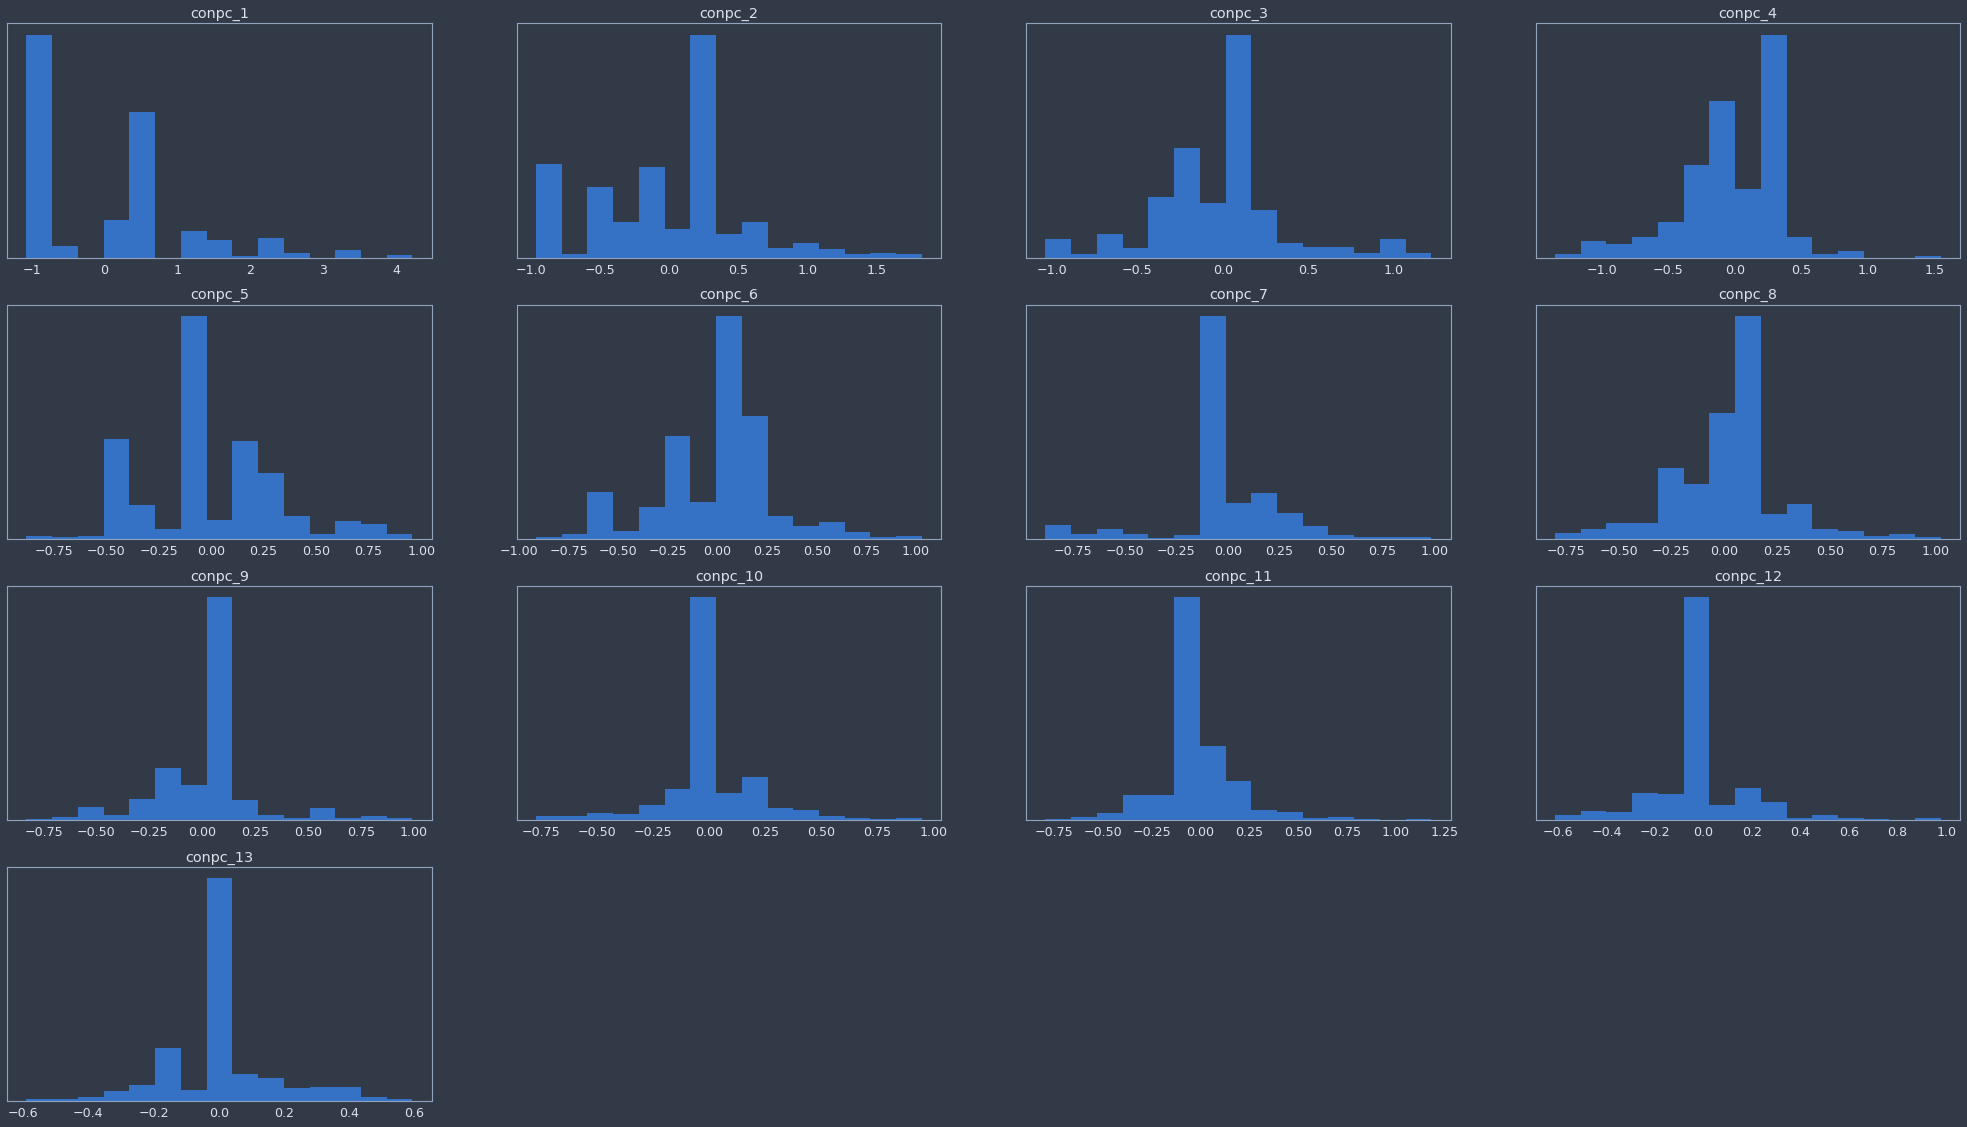

In [24]:
conpc_fg

##### Infection PCs

###### Compute

In [25]:
infpc_cs = [c for c in pca_df.columns if 'infpc' in c]
infpc_fg = plt.figure(figsize=(35,40))

for i,c in enumerate(infpc_cs):

    ax = infpc_fg.add_subplot(8,4,i+1)
    ax.hist(pca_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

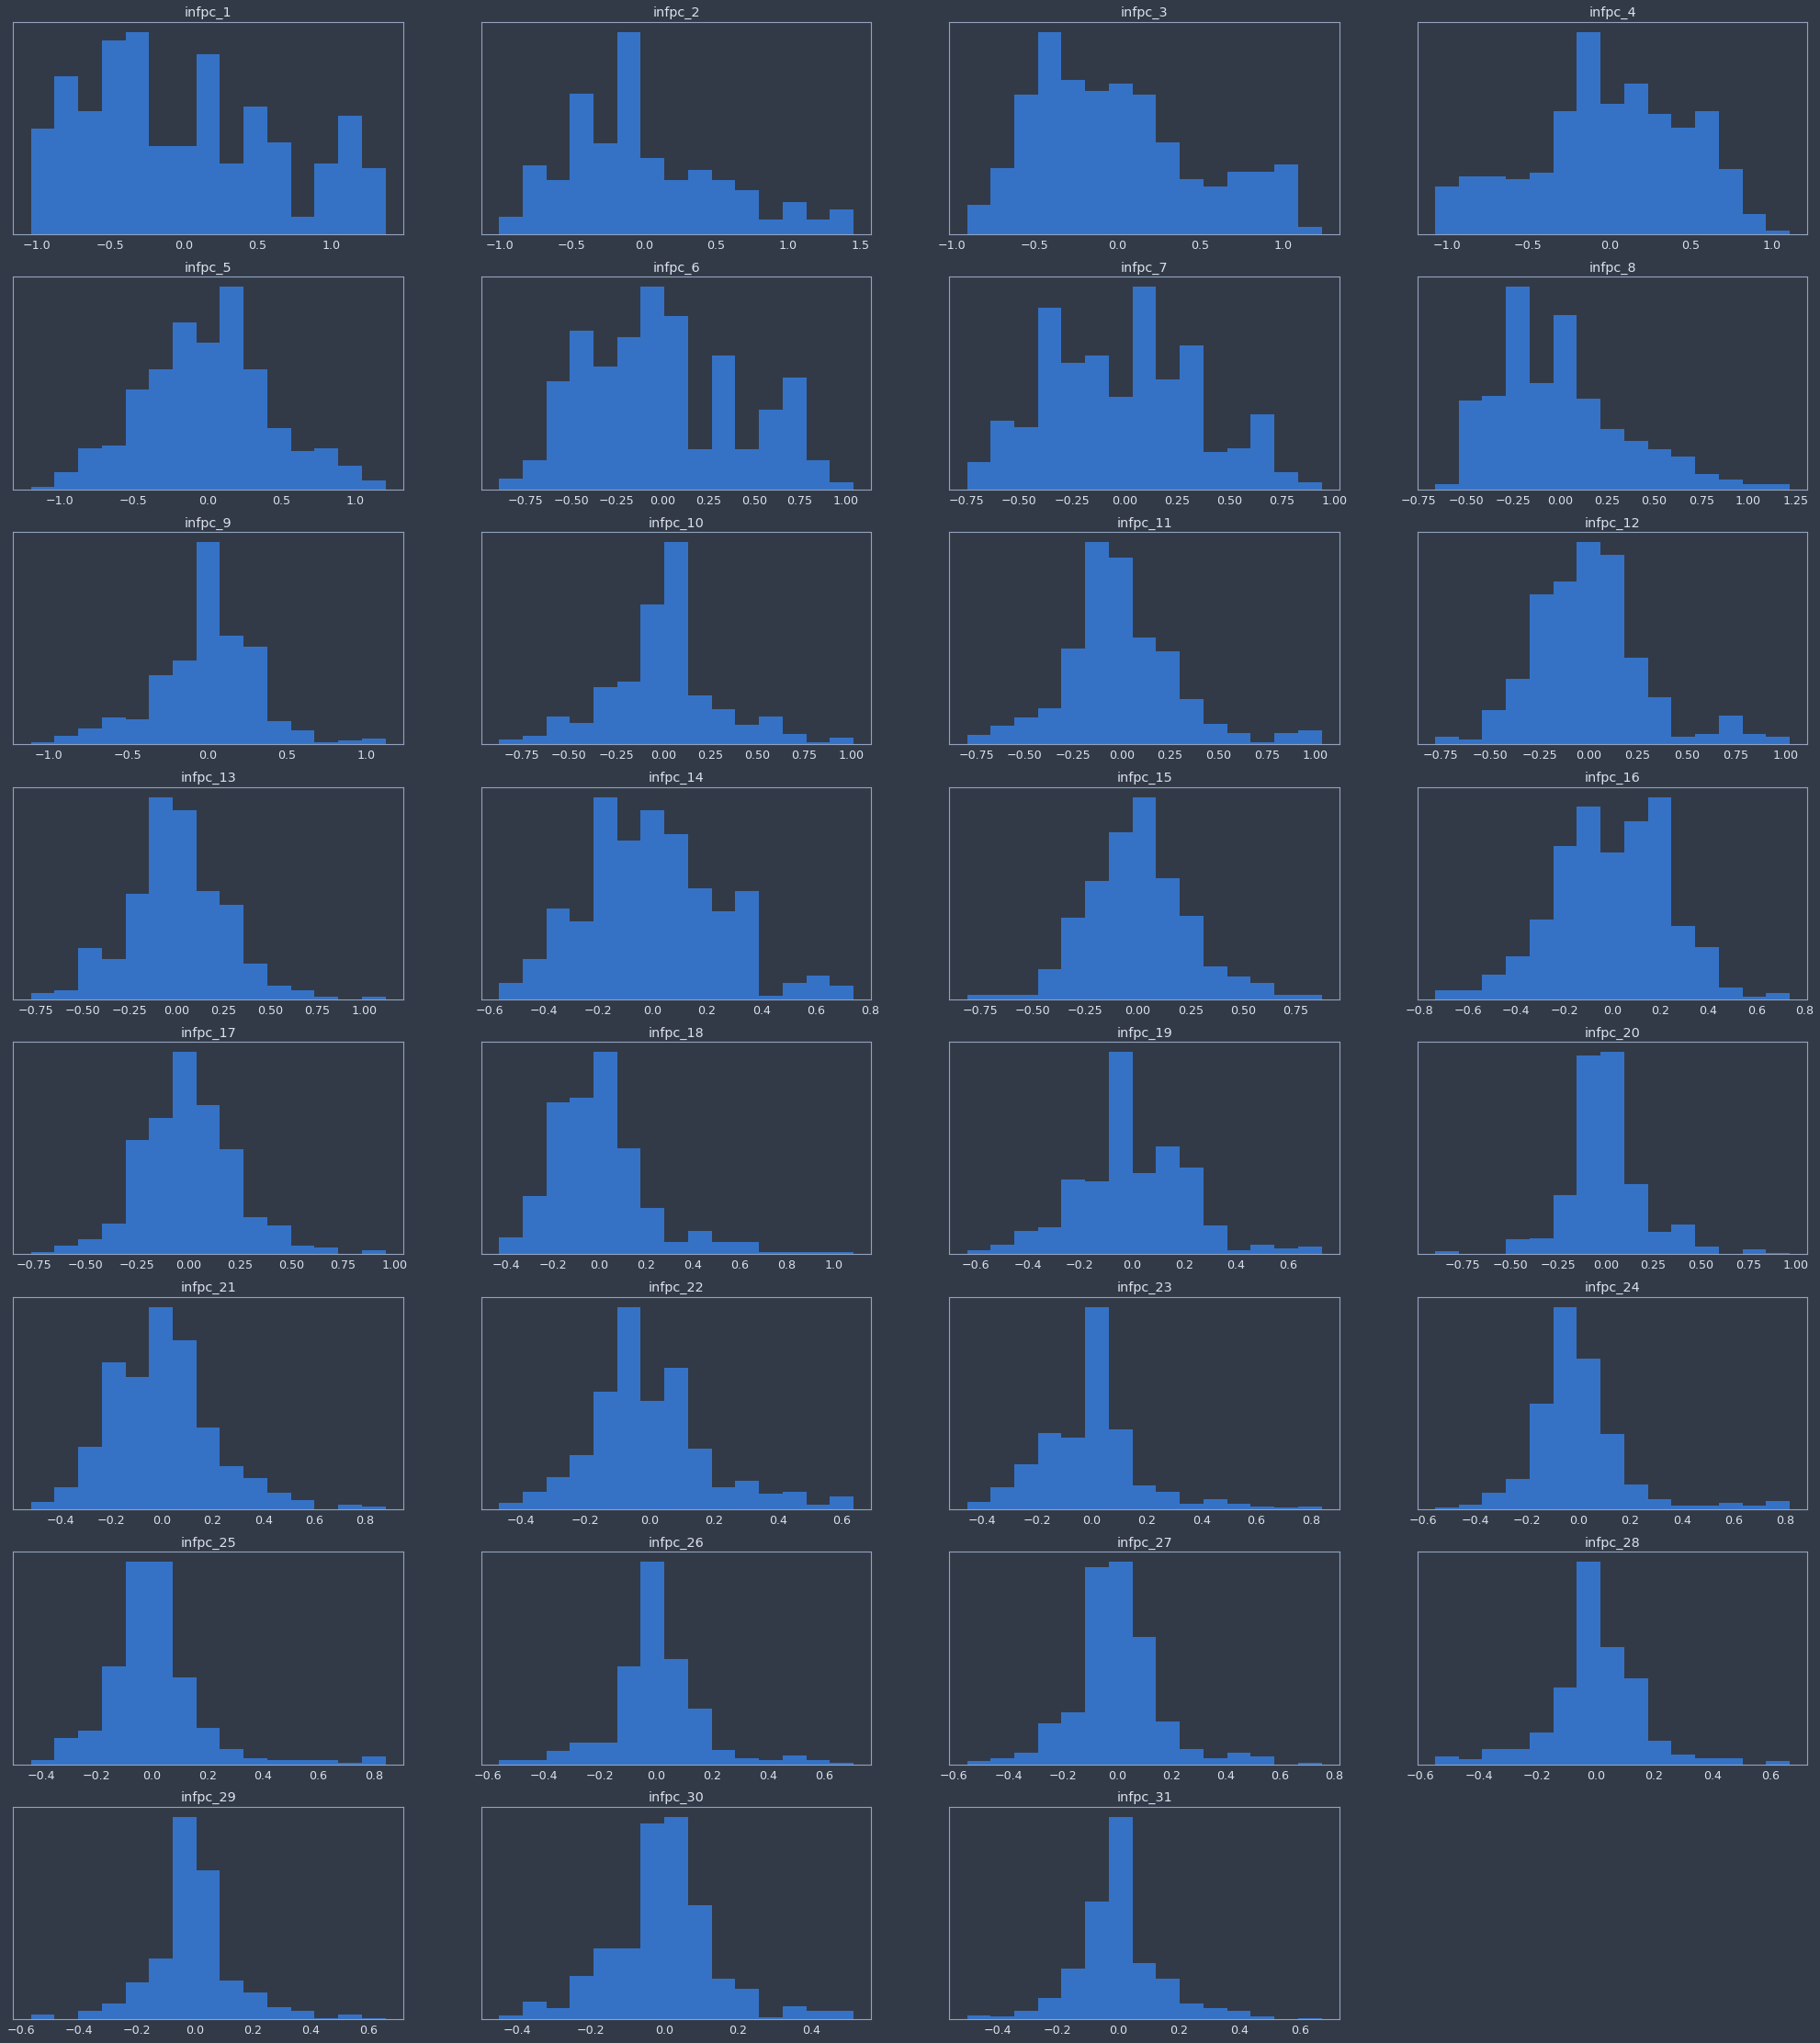

In [26]:
infpc_fg

##### Proteome

###### Compute

In [27]:
protein_cs = cp.deepcopy(sel_dc['proteome'])
protein_fg = plt.figure(figsize=(35,35))

for i,c in enumerate(protein_cs):

    ax = protein_fg.add_subplot(20,18,i+1)
    ax.hist(sel_df[c],color='w',density=True,label='original',bins=15)
    ax.hist(pca_df[c],alpha=.75,density=True,label='imputed',bins=15)
    ax.set_title(c,fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

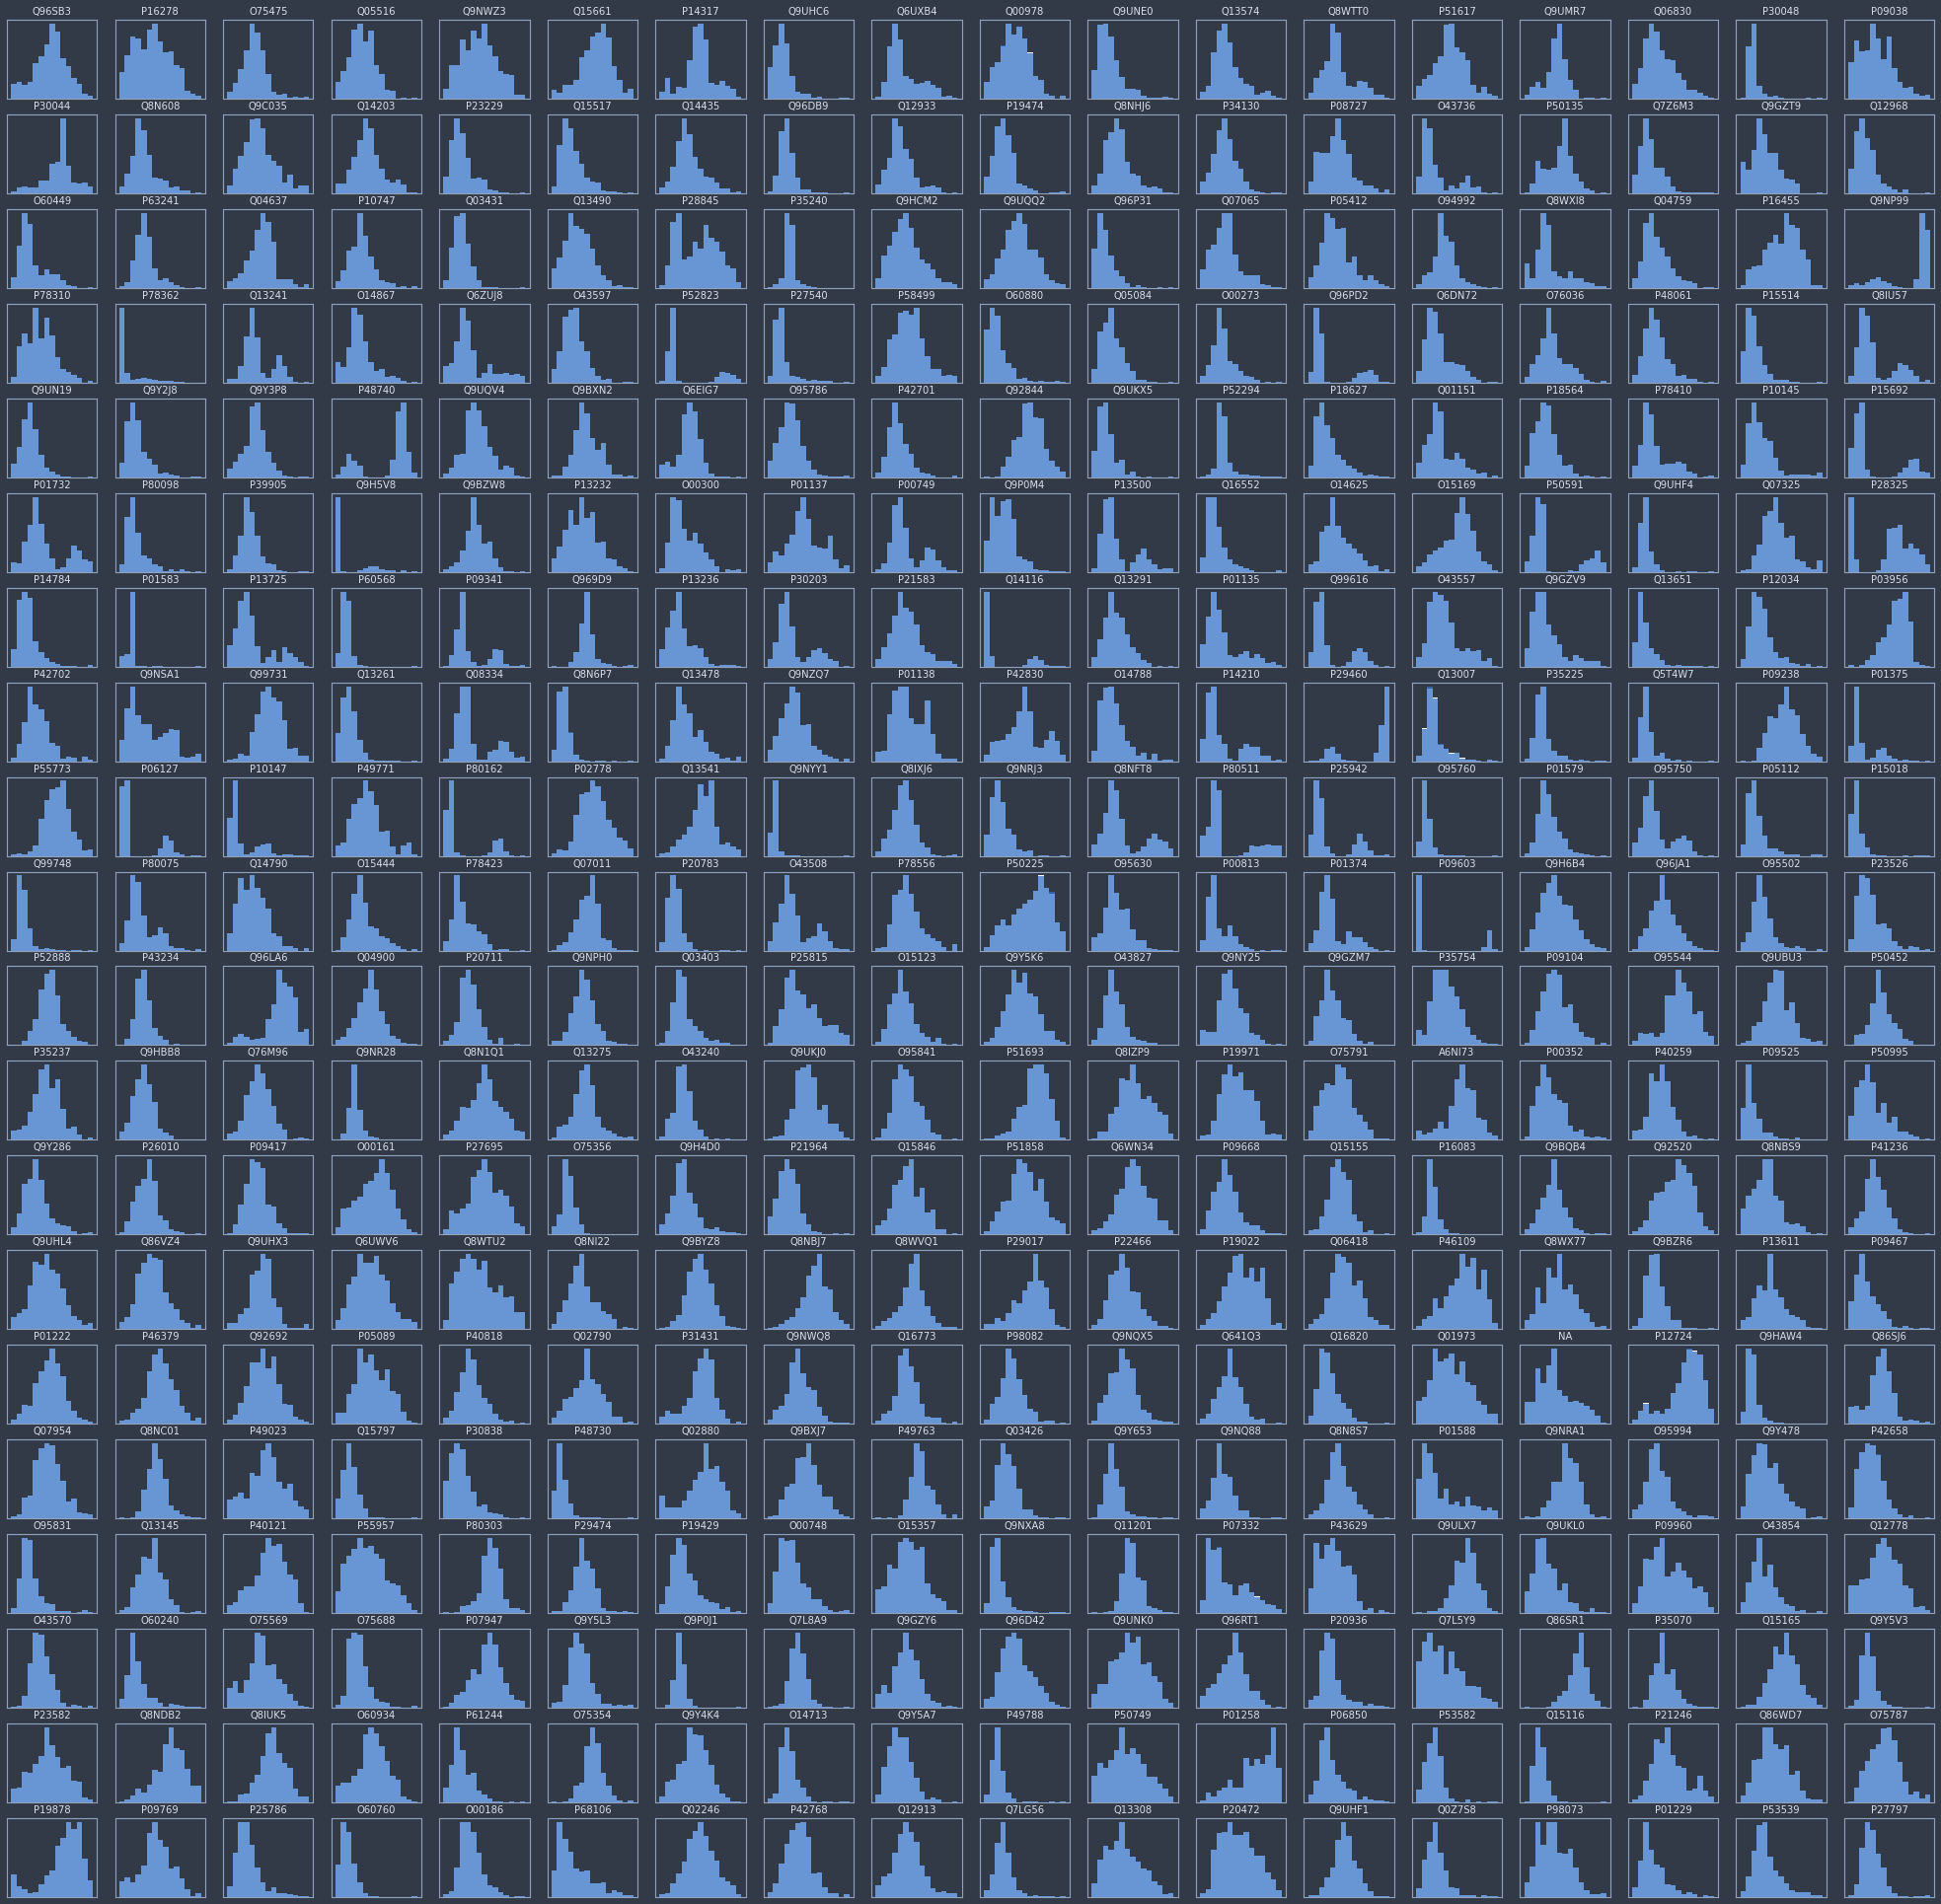

In [28]:
protein_fg

#### Log Scaling

In [29]:
log_df = pca_df.copy(deep=True)

inv_cs = ['sato2.low','gcs.low']

for c in inv_cs:
    log_df[c] = log_df[c].max()-log_df[c]

log_cs = ['conpc_1','sato2.low','cap.refill','gcs.low','fio2.high',\
          'wcc.high','wcc.low','anc.low','lymph.low','lactate.high',\
          'bili.high','crea.high','inr.high','alat.high','age.at.bc']\
         +[c for c in sel_dc['organs'] if 'cons' not in c]

for c in log_cs:
    log_df[c] = np.log(log_df[c]-log_df[c].min()+1)

#### Standard Scaling

In [30]:
sc = skp.StandardScaler()
std_df = pd.DataFrame(sc.fit_transform(log_df),\
                      columns=log_df.columns,\
                      index=log_df.index)
std_df

,temp.high,temp.low,rr.high,sato2.low,hr.high,cap.refill,sbp.low,map.low,gcs.low,fio2.high,...,infpc_22,infpc_23,infpc_24,infpc_25,infpc_26,infpc_27,infpc_28,infpc_29,infpc_30,infpc_31
BE-001,-0.208272,-0.625951,-0.076666,-0.516882,-0.476256,1.233399,-0.600364,-0.869426,1.313880,-0.370053,...,2.538929,-0.479085,0.268194,-0.698783,-1.325687,3.514697,2.461659,-0.817194,-0.667286,3.255489
BE-003,0.400806,-0.022456,-0.514414,-0.015399,-1.067187,-0.726941,0.191495,1.202997,1.313880,-0.370053,...,0.487132,0.393474,-0.976038,-0.891861,-0.597787,0.416739,-0.652689,-0.114008,-0.485400,-0.419083
BE-004,1.212910,3.357117,-0.319859,0.175256,-0.003512,-0.726941,0.424395,2.339486,-0.396578,-0.370053,...,-1.152535,0.226817,-0.795318,-0.412566,-2.144586,1.464756,0.505338,1.668932,-1.614586,-0.954558
BE-005,1.618962,0.460341,-0.319859,-0.516882,-0.771722,-0.726941,1.355995,0.601326,-0.396578,-0.370053,...,0.885604,0.420843,0.644473,-0.237786,-0.384043,-1.620362,-0.526873,-0.452314,-1.433934,2.172998
BE-007,-0.106759,1.184535,0.604276,-0.516882,-0.003512,-0.726941,0.750455,-0.200903,-0.396578,-0.370053,...,-0.847620,0.460159,-0.631912,-1.803472,-0.346816,0.927245,-0.821956,0.197784,0.575750,1.161590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZH-254,-0.005246,1.063836,1.625688,1.749673,1.001070,1.746733,-1.159324,-1.069983,-0.396578,-0.370053,...,-0.075750,1.973975,0.202867,-1.720660,-0.340133,-1.876365,-2.663232,-0.970209,2.807546,0.044481
ZH-255,-1.020376,-0.022456,2.112075,1.410247,0.351046,1.233399,-1.718283,-1.337392,2.393059,4.239482,...,-0.360413,-0.056066,-0.100879,-0.032314,-0.054427,-0.200263,0.643657,-0.187532,0.259947,-0.156681
ZH-257,0.400806,1.063836,0.069250,-0.240896,1.060163,1.233399,2.427334,1.938372,-0.396578,-0.370053,...,-1.196513,0.328345,-0.780075,4.069093,-2.966518,1.719395,-1.612959,-1.188093,1.375248,0.942394
ZH-258,-0.208272,-0.384553,0.117889,-0.872690,-0.121698,-0.726941,-0.320884,-0.535164,-0.396578,-0.370053,...,-0.231685,-0.913883,-0.949714,-1.575055,-0.719495,0.667349,0.673137,0.531526,0.822674,0.095094


#### Standardized Distributions

##### Physiology

###### Compute

In [31]:
physdist_fg2 = plt.figure(figsize=(35,50))

for i,c in enumerate(physio_cs):

    ax = physdist_fg2.add_subplot(10,4,i+1)
    ax.hist(std_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

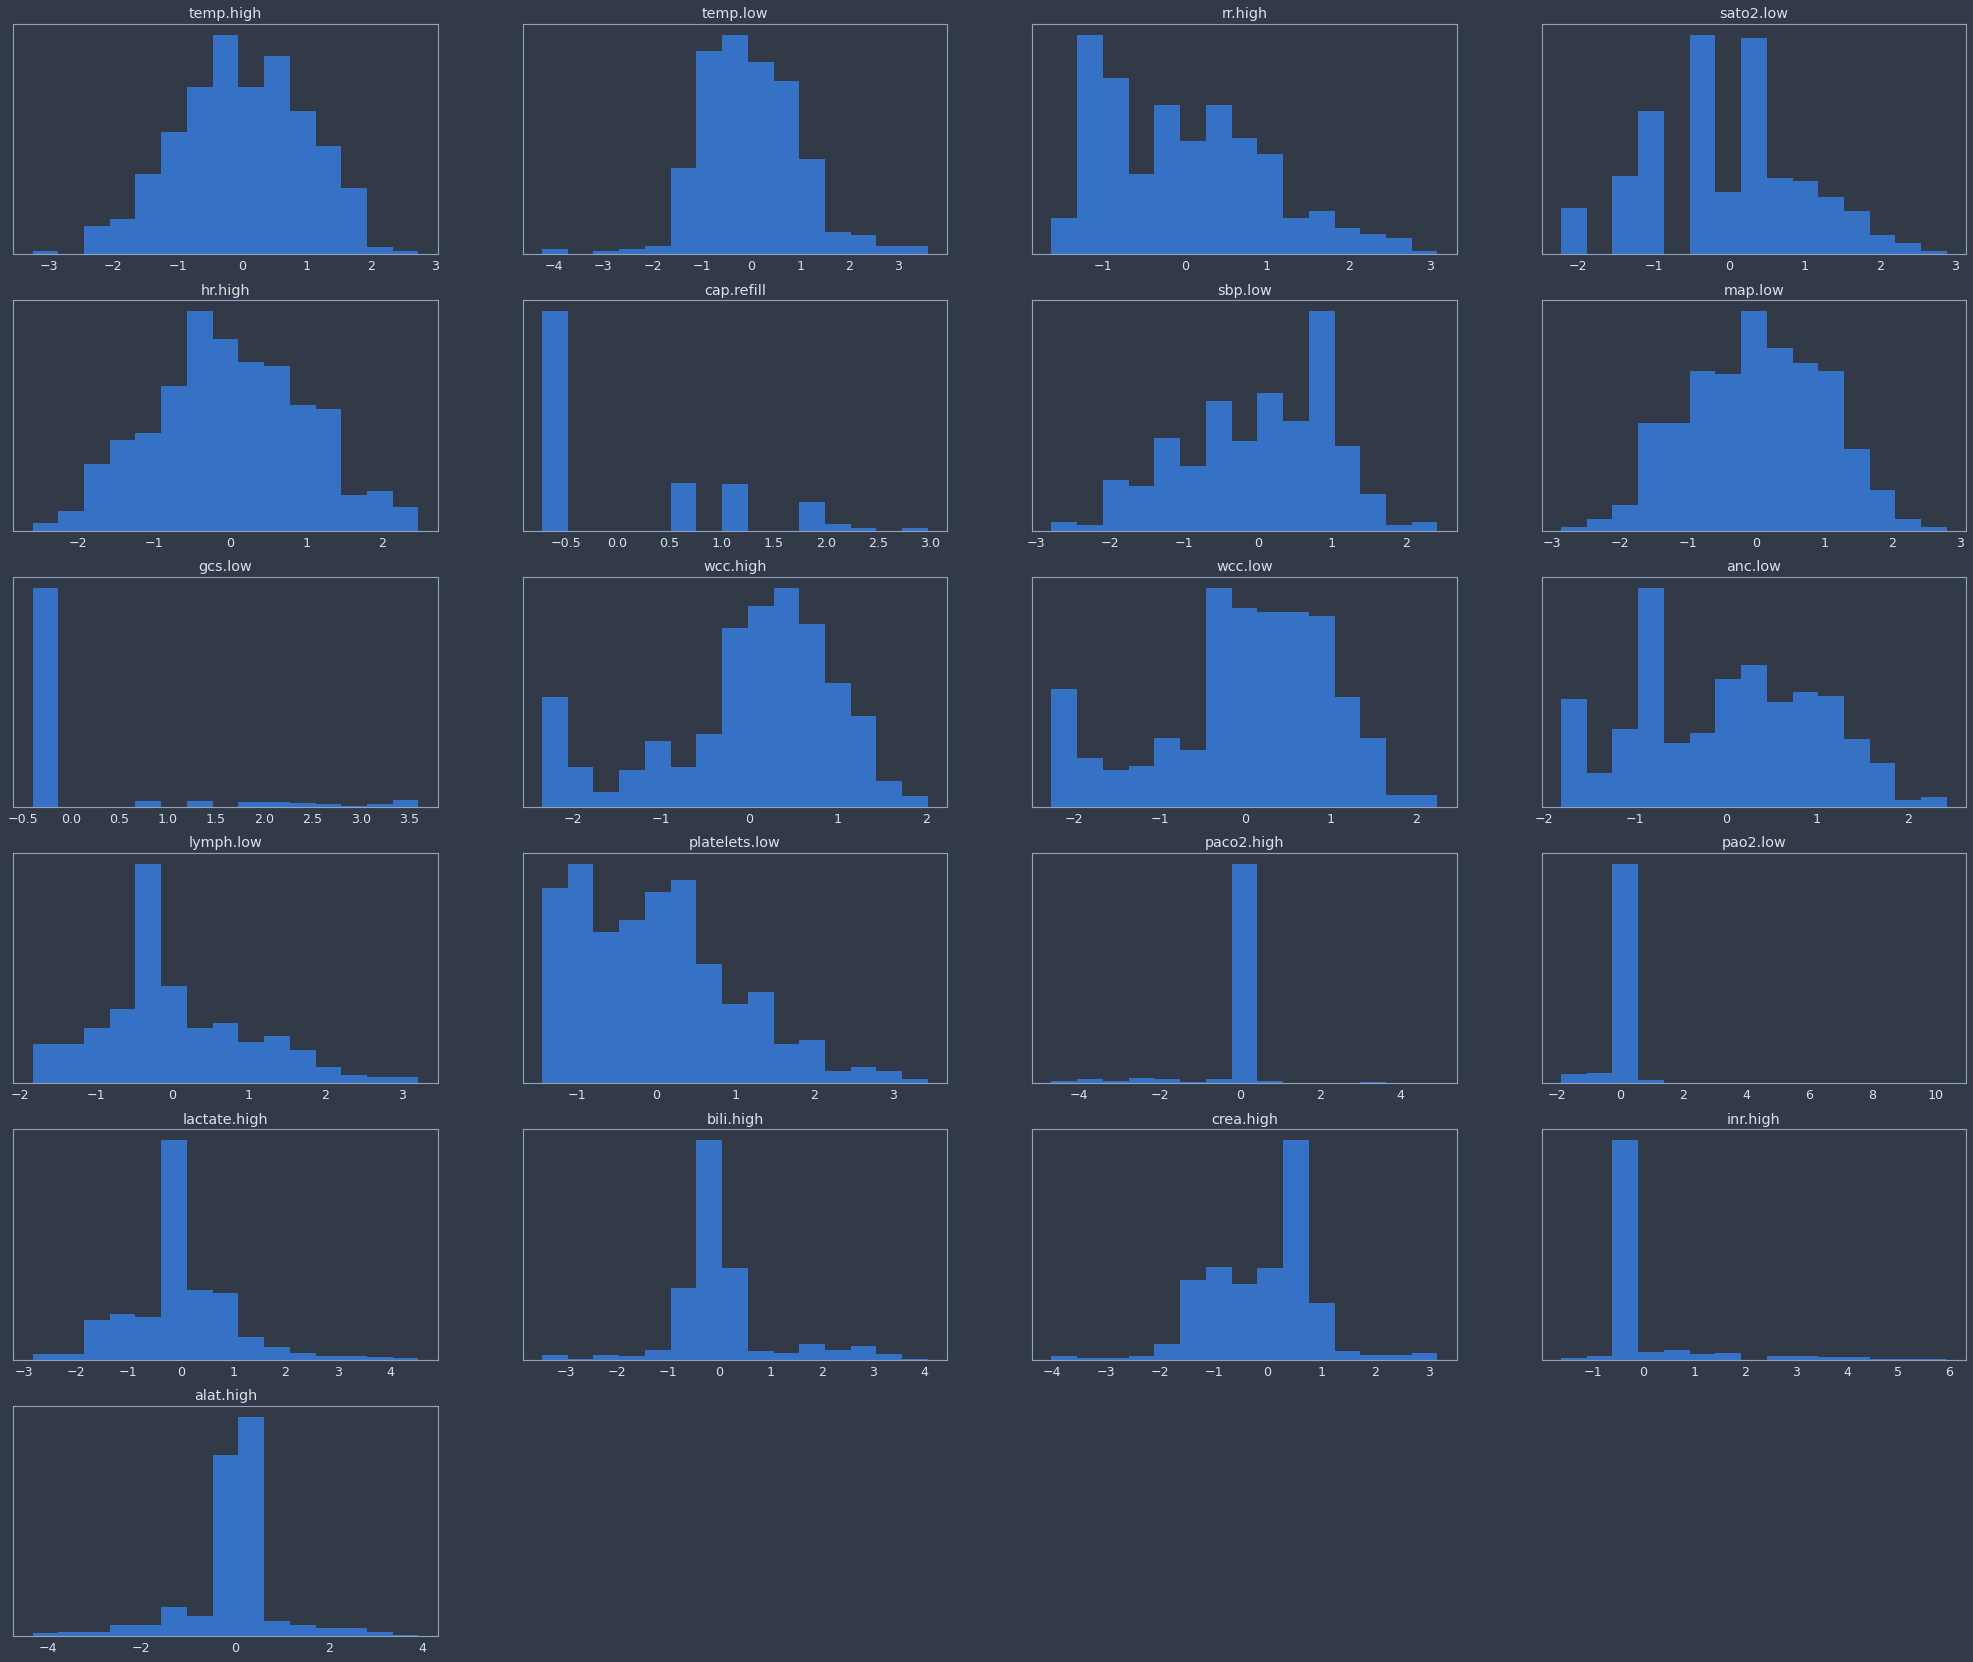

In [32]:
physdist_fg2

##### Contextual PCs

###### Compute

In [33]:
conpc_fg2 = plt.figure(figsize=(35,25))

for i,c in enumerate(conpc_cs):

    ax = conpc_fg2.add_subplot(5,4,i+1)
    ax.hist(std_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

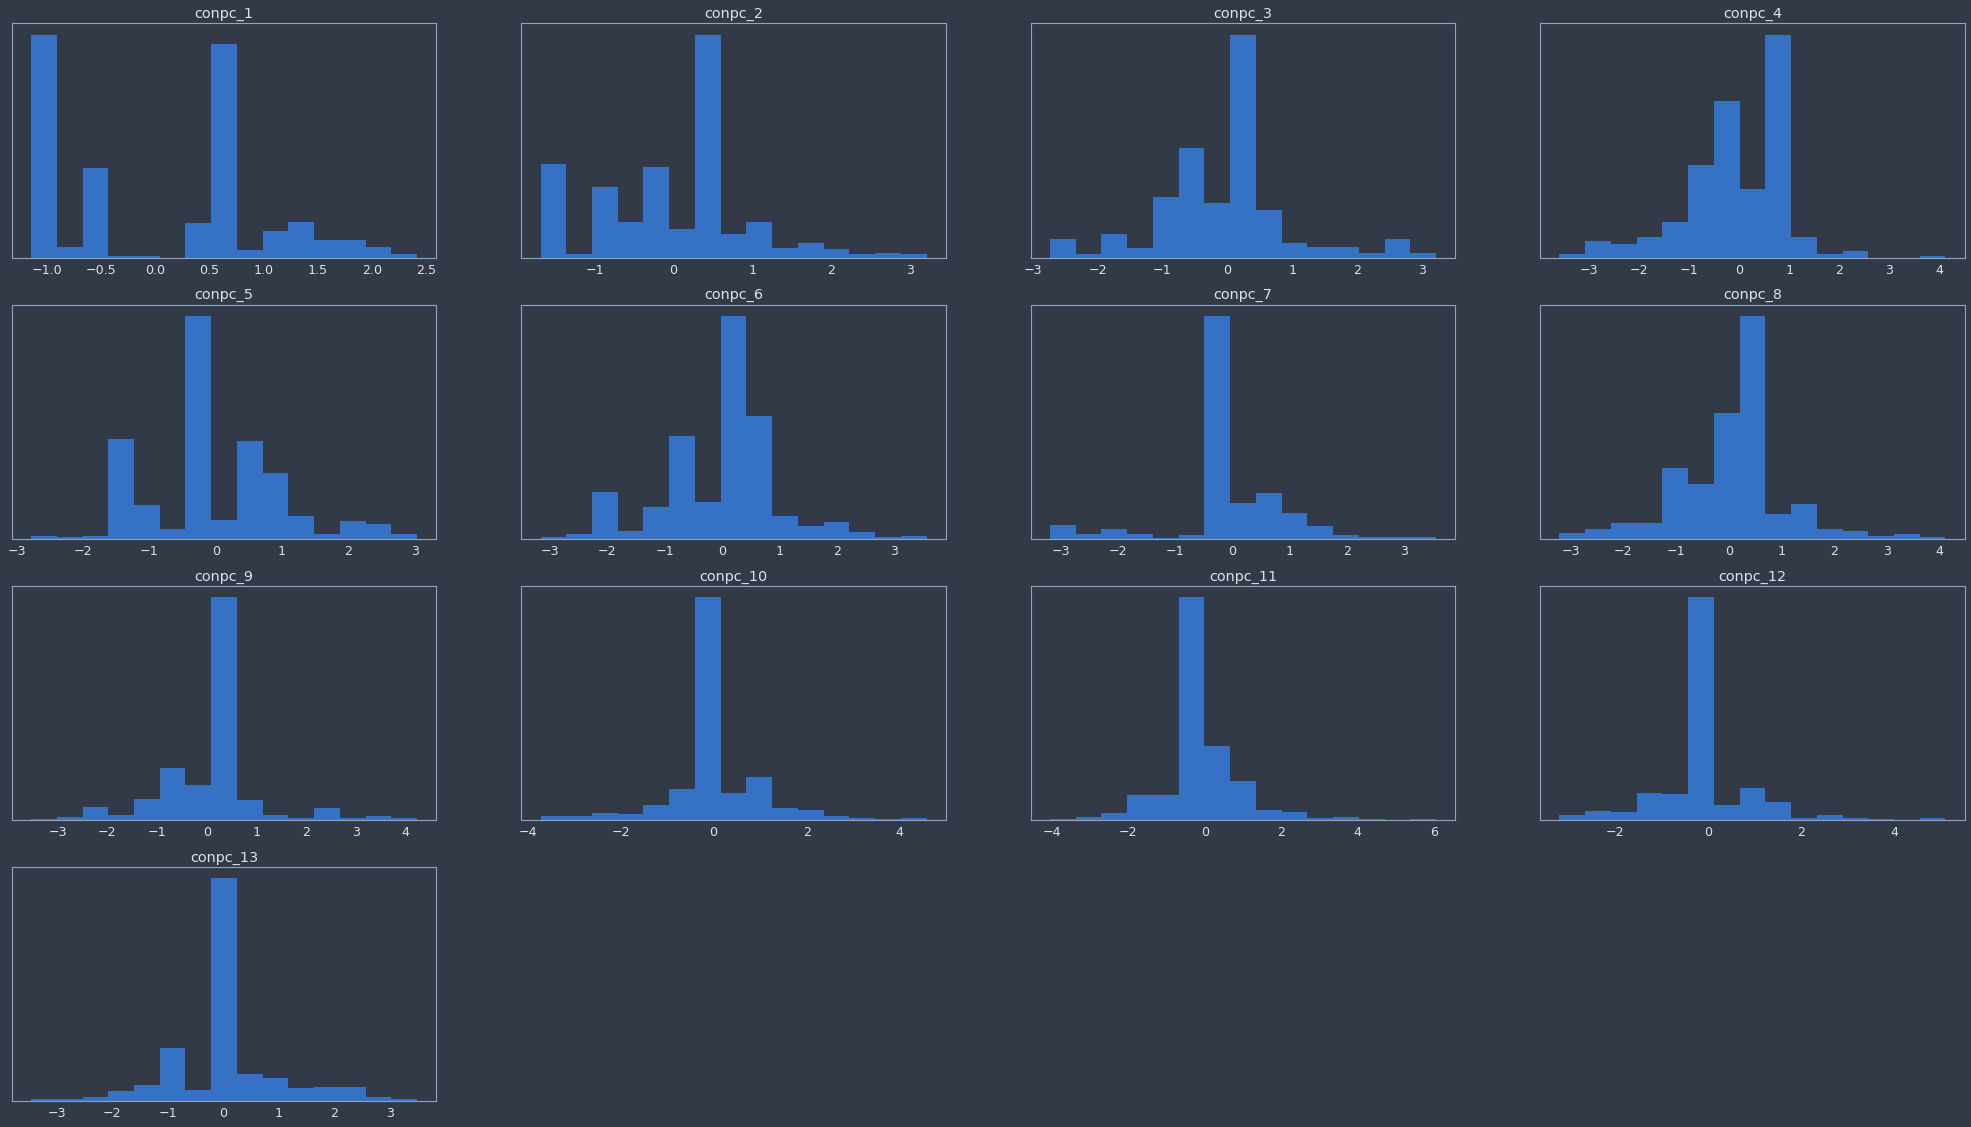

In [34]:
conpc_fg2

##### Infection PCs

###### Compute

In [35]:
infpc_fg2 = plt.figure(figsize=(35,40))

for i,c in enumerate(infpc_cs):

    ax = infpc_fg2.add_subplot(8,4,i+1)
    ax.hist(std_df[c],density=True,bins=15)
    ax.set_title(c)
    ax.set_yticks([])
    ax.grid(False)

plt.close()

###### Figure

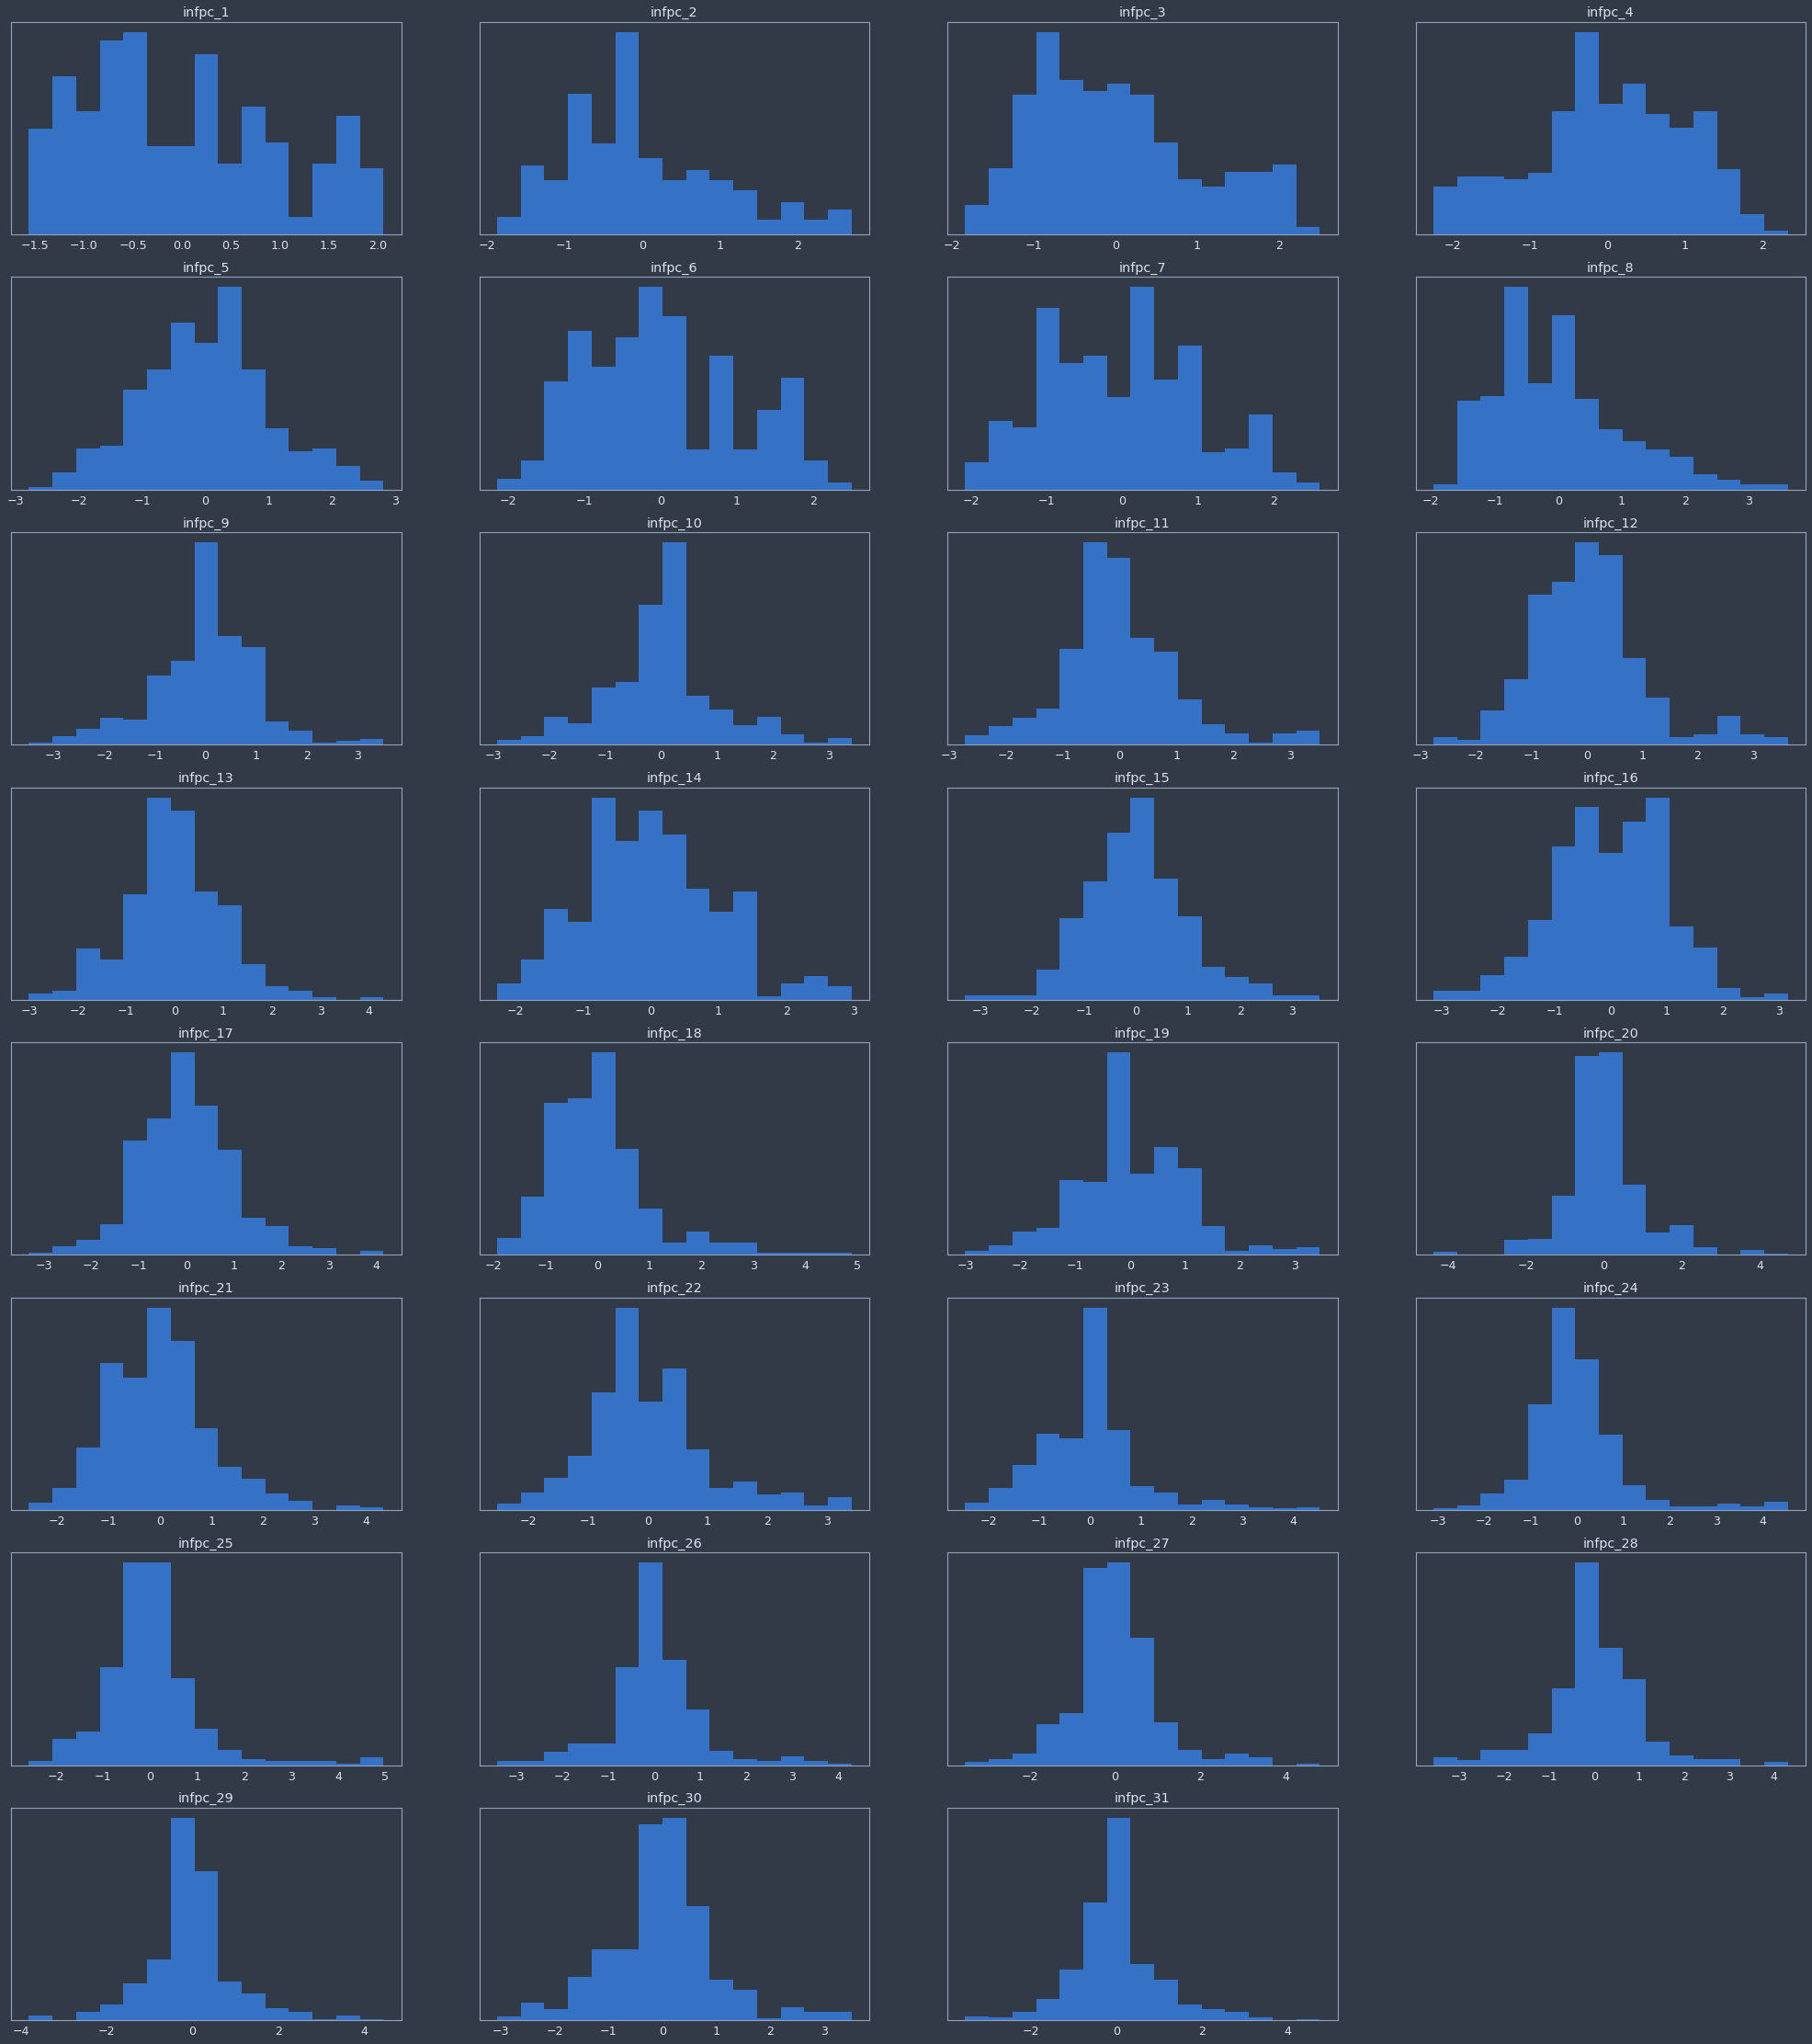

In [36]:
infpc_fg2

## Analysis

### Single-Protein Clustering Based on Bimodal Proteins

###### Find Bimodal Proteins

In [37]:
pro_df  = imp_df[protein_cs].copy(deep=True)
bim_fig = plt.figure(figsize=(24,13.5))
b       = 19
bims    = {}
i       = 1

for p in pro_df.columns:

    X   = pro_df.loc[:,p].values
    kde = skn.KernelDensity(kernel='gaussian',bandwidth=1).fit(X.reshape(-1,1))
    y,x = np.histogram(X,bins=b)
    w   = x[1]-x[0]
    x   = x[:,np.newaxis]
    k   = np.exp(kde.score_samples(x))
    dk  = np.gradient(k)
    ddk = np.gradient(dk)
    sk  = np.sign(dk)
    ssk = np.sign(ddk)
    C1  = sk[1:]-sk[:-1]!=0
    C2  = ddk[1:]>.0001
    C   = np.concatenate([[False],C1&C2])
    x0s = x[C]
    
    if len(x0s)!=0:
        
        tx0s = []
        
        for x0 in x0s:
            C3 = y[:np.where(x==x0)[0][0]].sum()/y.sum()>.2
            C4 = y[np.where(x==x0)[0][0]:].sum()/y.sum()>.2
            if C3&C4:
                tx0s += [x0]
        
        if len(tx0s)!=0:
            
            ax = bim_fig.add_subplot(5,7,i)
            ax.hist(X,bins=b,density=True)
        
            for tx0 in tx0s:
                ax.axvline(tx0-w/2,lw=2,color='white')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_title(p)
            
            bims[p] = tx0s[0][0]
            i+=1
            
plt.close()

###### Figure

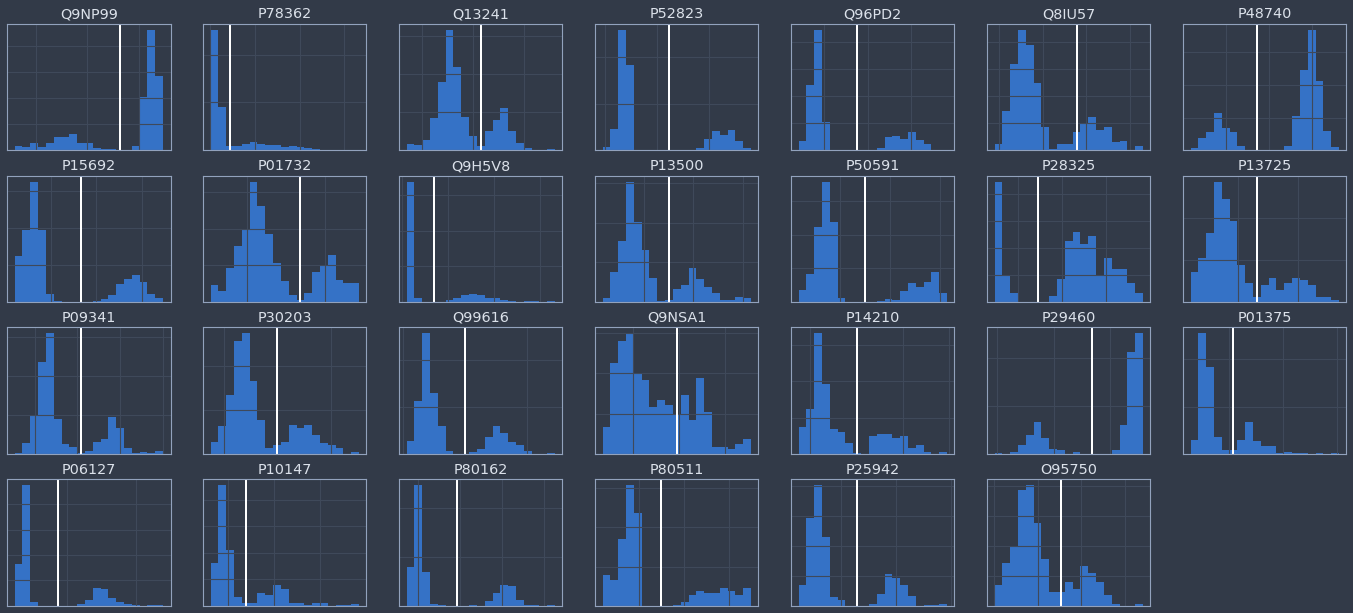

In [38]:
bim_fig

###### Associated Physiology

In [39]:
bimphy_fig,df = protein_f_association(bims,'physio',sel_dc['physio'],.05,'f-test')

###### Figure

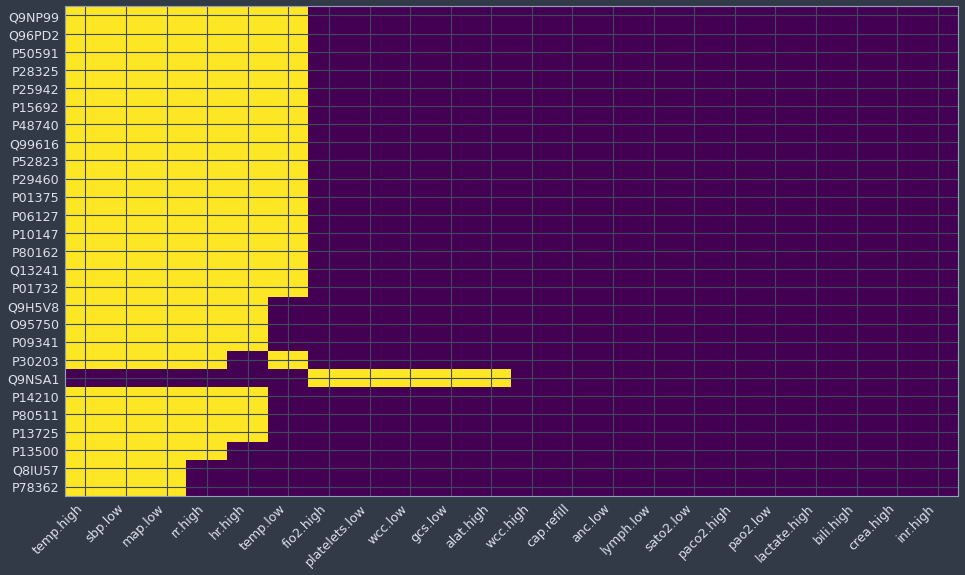

In [40]:
bimphy_fig

###### Associated Organs

In [41]:
test_cs       = [c for c in sel_dc['organs'] if ('cons' not in c) and ('score' not in c)]
bimorg_fig,df = protein_f_association(bims,'organs',test_cs,.05,'f-test')

###### Figure

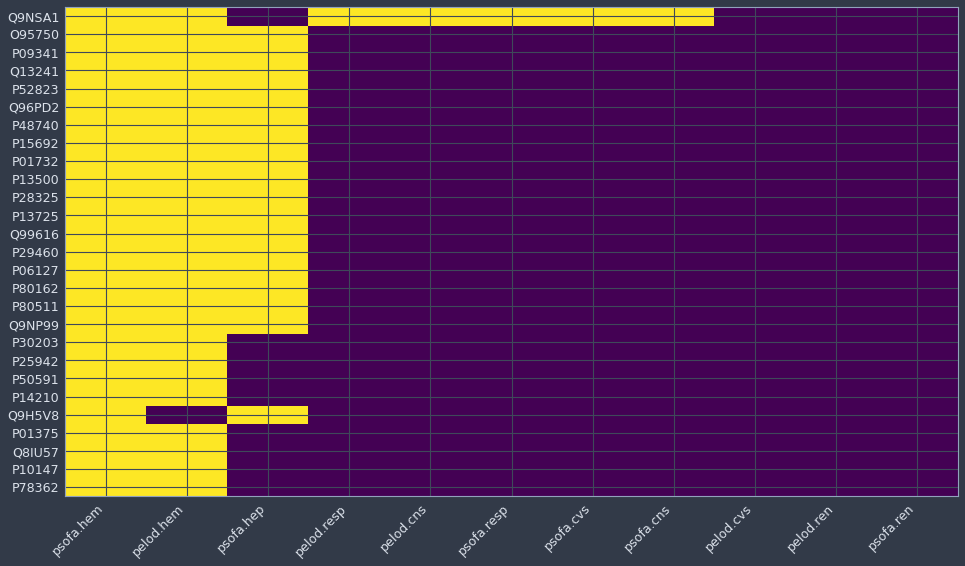

In [42]:
bimorg_fig

###### Associated Chronic Condition

In [43]:
test_cs       = [c for c in sel_dc['chronic_conditions'] if ('cate' not in c) and ('summary' not in c)]
bimccc_fig,df = protein_f_association(bims,'chronic_conditions',test_cs,.05,'fisher')

###### Figure

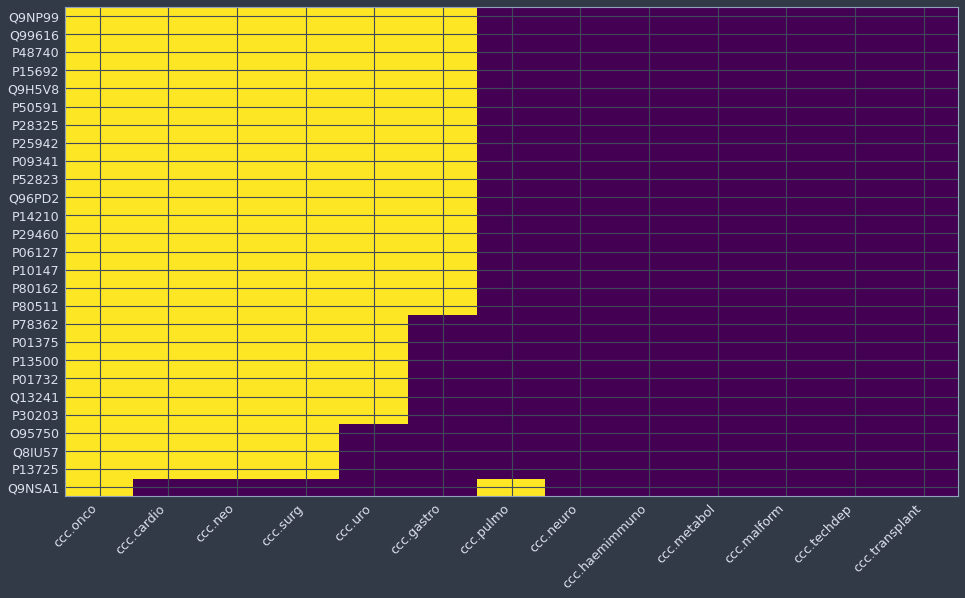

In [44]:
bimccc_fig

###### Associated Infection Focus

In [45]:
test_cs       = [c for c in sel_dc['infections']]
biminf_fig,df = protein_f_association(bims,'infections',test_cs,.05,'fisher')

###### Figure

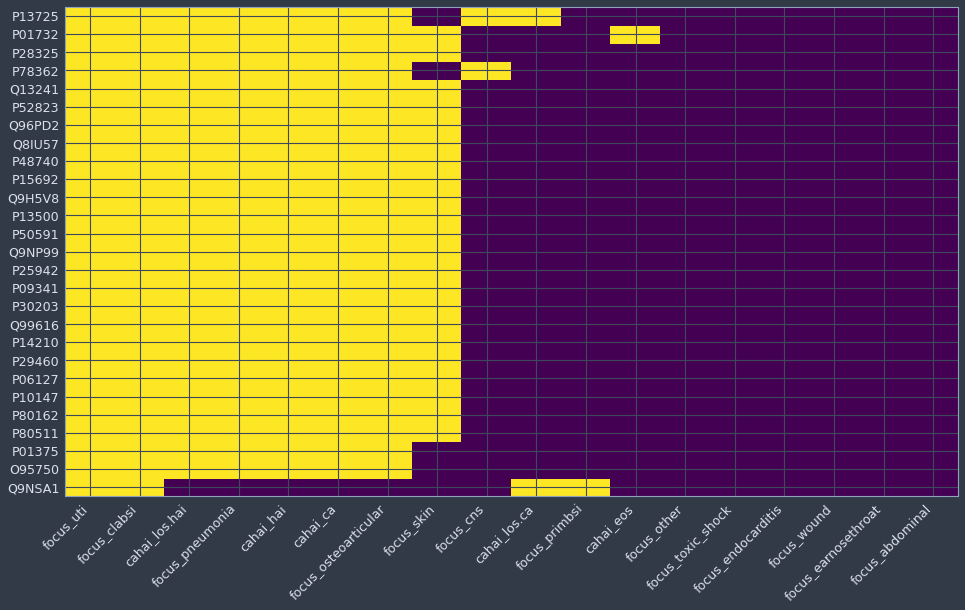

In [46]:
biminf_fig

###### Associated Pathogen

In [47]:
test_cs       = [c for c in sel_dc['pathogen']]
bimpat_fig,df = protein_f_association(bims,'pathogen',test_cs,.05,'fisher')

###### Figure

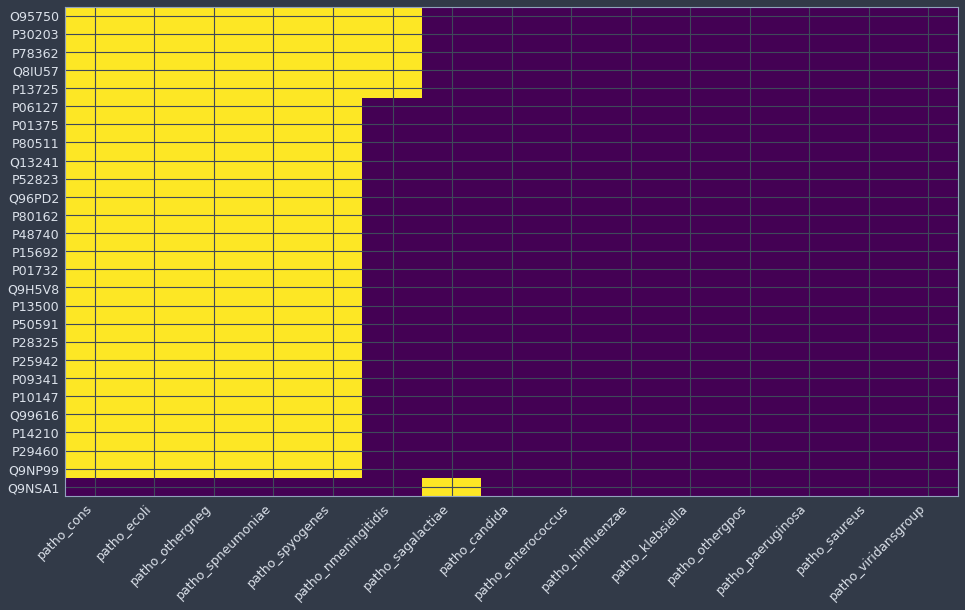

In [48]:
bimpat_fig

###### Associated Demographics

In [49]:
test_cs       = [c for c in sel_dc['demographics'] if 'age' not in c]
bimdem_fig,df = protein_f_association(bims,'demographics',test_cs,.05,'fisher')

###### Figure

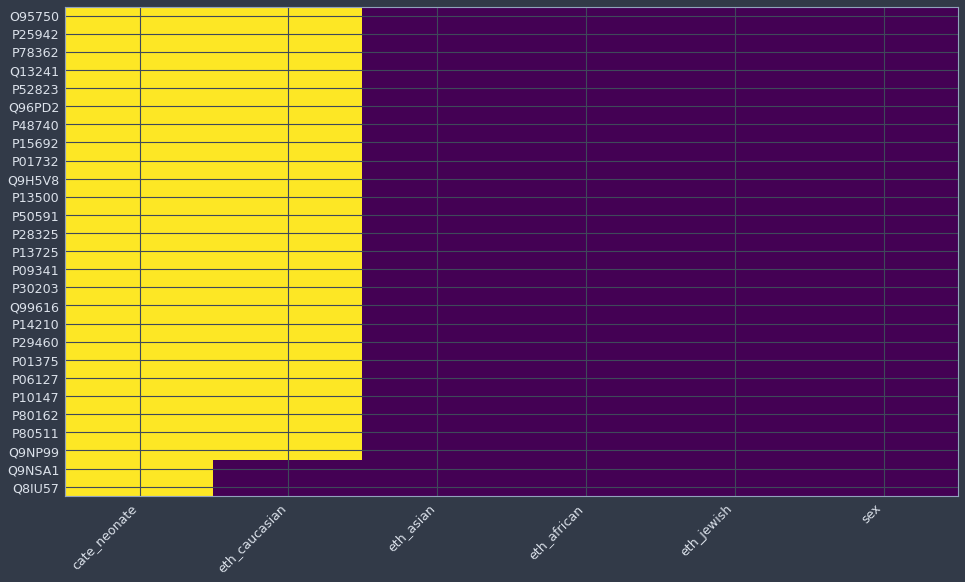

In [50]:
bimdem_fig

###### Associated Proteins

In [51]:
test_cs = sel_dc['proteome']
bimpro_fig,bimpro_df = protein_f_association(bims,'proteome',test_cs,.05,'f-test')

###### Figure

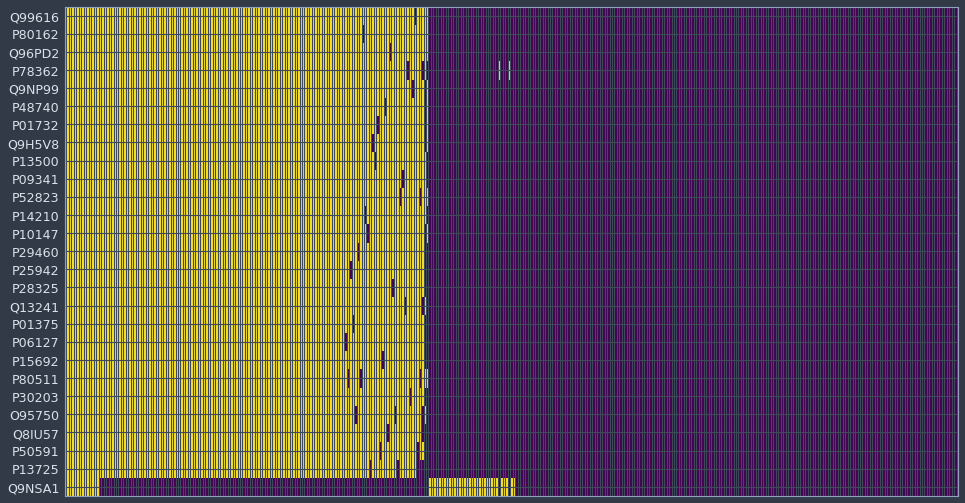

In [52]:
bimpro_fig

###### Groups of Proteins

In [53]:
bim_lst    = bimpro_df.index.tolist()
asso_lst   = bimpro_df.T[bimpro_df.sum(axis=0)>=2].index.tolist()
q9nsa1_lst = bimpro_df.T[bimpro_df.T.Q9NSA1==1].index.tolist()

bim2_lst   = [c for c in bim_lst if c in asso_lst]

venn_fig = plt.figure(figsize=(6,6))

A   = bim_lst
B   = asso_lst
C   = q9nsa1_lst
AB  = [a for a in A if a in B]
AC  = [a for a in A if a in C]
BC  = [b for b in B if b in C]
ABC = [a for a in AB if a in C]

v = mpv.venn3(subsets=(len(A)-len(AB)-len(AC)+len(ABC),\
                   len(B)-len(AB)-len(BC)+len(ABC),\
                   len(AB),\
                   len(C)-len(AC)-len(BC)+len(ABC),\
                   len(AC)-len(ABC),\
                   len(BC)-len(ABC),\
                   len(ABC)),\
          set_labels = ('Bimodal','Associated','Q9NSA1'))

plt.close()

###### Figure

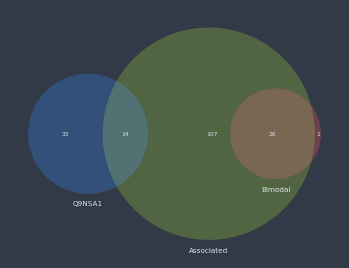

In [54]:
venn_fig

### Single-View Clustering

#### Search Grid

In [55]:
n_states = 10**2
n_comps  = [2]
epss     = np.linspace(.1,10,100)
minss    = np.arange(10,41)

#### Confounders

In [56]:
dem_df = std_df[dempc_cs+['age.at.bc']].copy(deep=True)

#### Physiological View

##### Definition

###### Definition

In [57]:
phy_df = std_df[physio_cs].copy(deep=True)

###### Orthogonalization

In [58]:
phy_odf = ortho_project(phy_df,dem_df)

##### DBSCAN Optimization

###### Grid Search

In [59]:
label     = 'physio'
phyopt_df = cluster_optimization(phy_odf,n_states,n_comps,epss,minss,label)
phyopt_df.head(3)

,dim,state,epsilon,n_mins,n_clusters,silhouette
2288,2,34,7.4,35,3,0.278066
2129,2,34,6.9,31,3,0.244705
2416,2,34,7.8,39,4,0.240326


###### Compute Silhouettes

In [60]:
phyts_df,phyclu_df = optimal_clusters(phy_odf,phyopt_df)
phyts_fig          = cluster_fig(phyts_df,phyclu_df,'dbscan')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


###### Figure

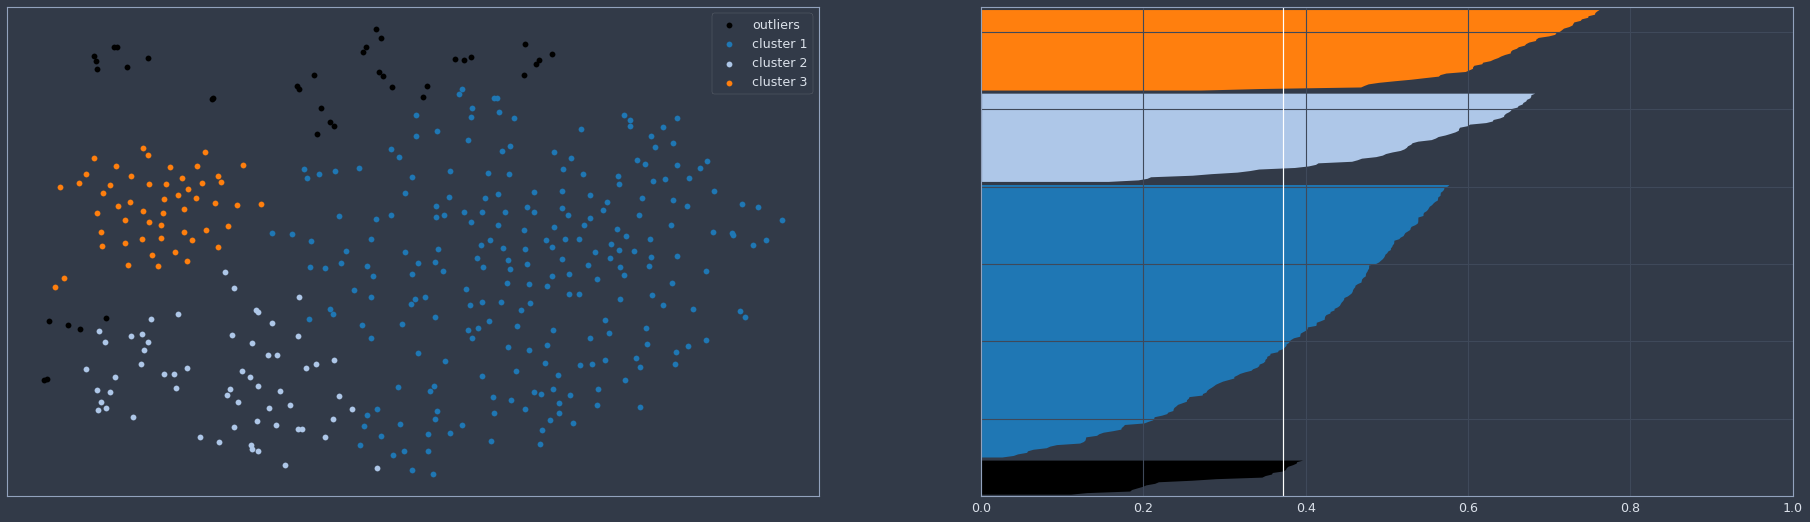

In [61]:
phyts_fig

##### Hierarchical Clustering

###### Compute

In [62]:
phyhie_fig,phyhie_df = hierarchical_cluster(phyts_df,3)
phyhie_fig2          = cluster_fig(phyts_df,phyhie_df,'hieclu')

###### Figure

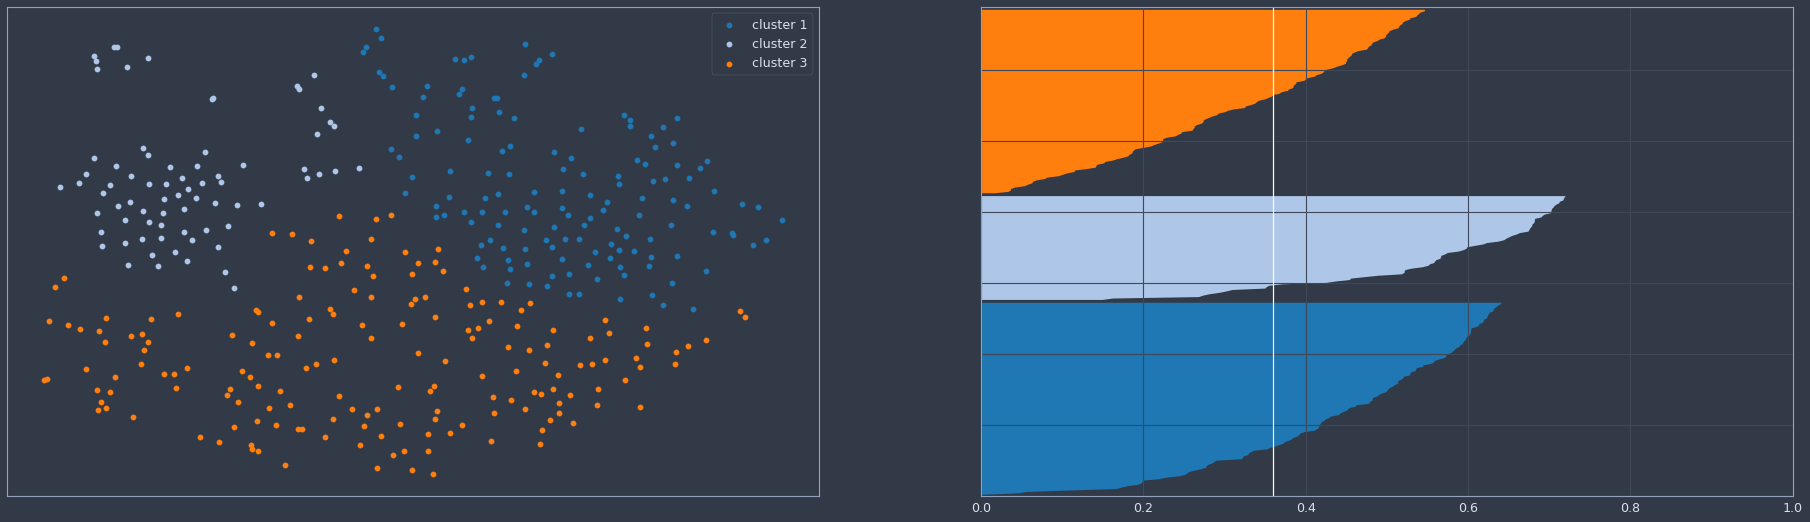

In [63]:
phyhie_fig2

##### F-Test

###### Compute

In [64]:
sel_dc['continuous'] = sel_dc['physio']+\
                       [c for c in sel_dc['organs'] if ('cons' not in c) or ('summary' in c)]+\
                       [c for c in sel_dc['demographics'] if 'age' in c]+\
                       [c for c in sel_dc['chronic_conditions'] if 'summary' in c]+\
                       sel_dc['proteome']
sel_dc['binary']     = [c for c in sel_dc['organs'] if ('cons' in c) and ('summary' not in c)]+\
                       [c for c in sel_dc['demographics'] if 'age' not in c]+\
                       [c for c in sel_dc['chronic_conditions'] if 'summary' not in c]+\
                       sel_dc['infections']+\
                       sel_dc['pathogen']+\
                       sel_dc['treatment']

In [65]:
contest_cs = sel_dc['continuous']+['physio_cluster']
impsv_df = assign_clusters(imp_df,phyhie_df,label,'hieclu')
phyf_df,phynull_df = f_pvalues(impsv_df[contest_cs],label,.05)
phyfstat_fig = fstat_fig(impsv_df,phyf_df,label)
phyf_df.head(10)

,p_value,f_stat
pelod.hem,0.000126,212.688760
psofa.hem,0.000126,106.549202
Q96LA6,0.000126,99.807847
Q8IZP9,0.000126,94.393925
P19878,0.000126,89.078540
P12724,0.000126,88.372185
Q8NBJ7,0.000126,81.045434
age.at.bc,0.000126,80.768299
Q8WTU2,0.000126,78.955389
Q9UMR7,0.000126,77.621959


###### Figure

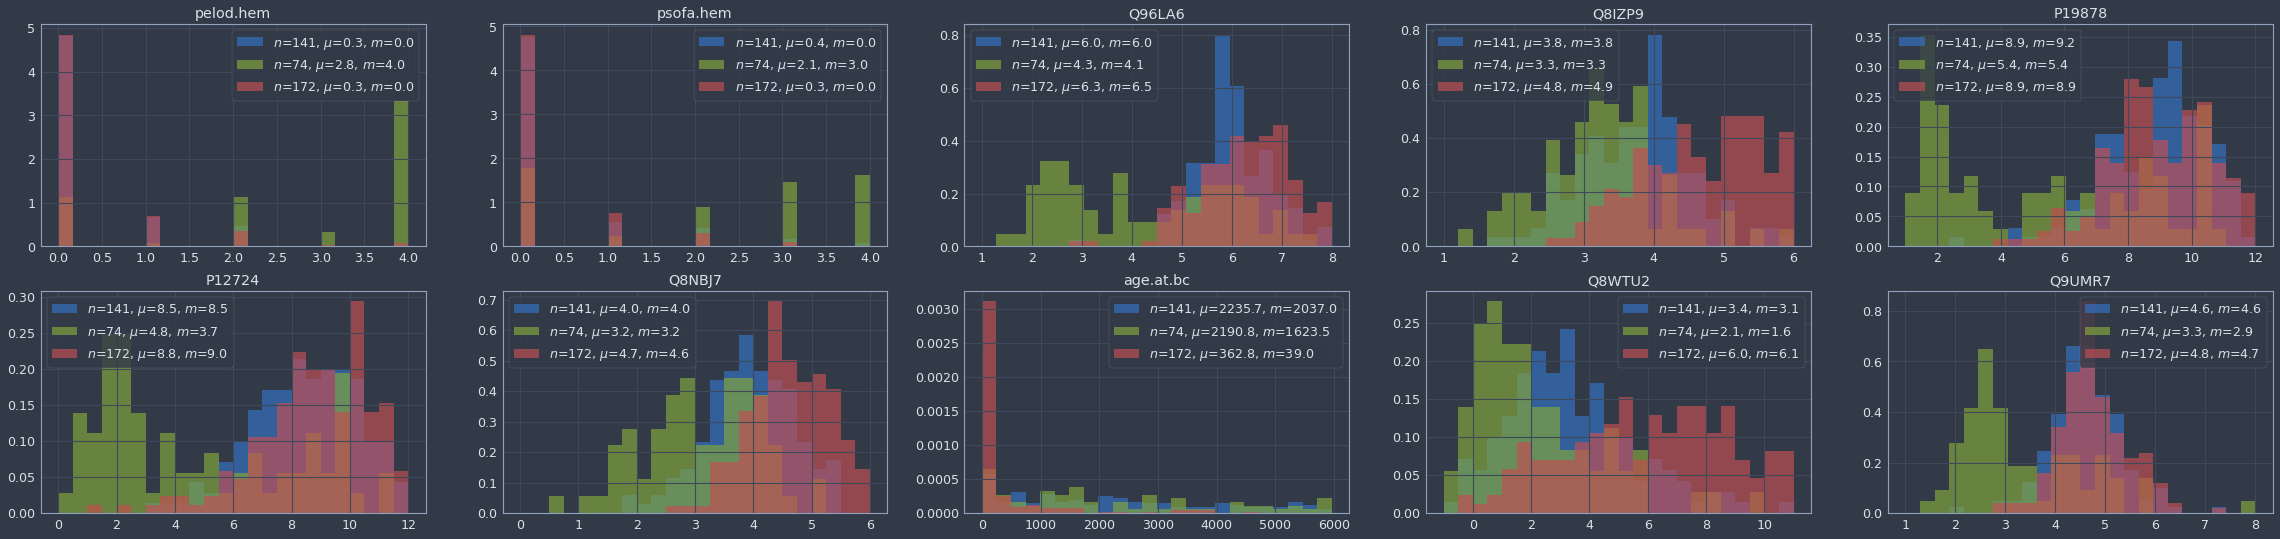

In [66]:
phyfstat_fig

#### Contextual View

##### Definition

###### Definition

In [67]:
con_df = std_df[conpc_cs+infpc_cs+['fio2.high']].copy(deep=True)

###### Orthogonalization

In [68]:
con_odf = ortho_project(con_df,dem_df)

##### Clustering Optimization

###### Grid Search

In [69]:
label     = 'context'
conopt_df = cluster_optimization(con_odf,n_states,n_comps,epss,minss,label)
conopt_df.head(3)

,dim,state,epsilon,n_mins,n_clusters,silhouette
1675,2,11,5.5,11,2,0.173501
1706,2,11,5.6,11,2,0.173501
1799,2,11,5.9,11,2,0.173501


###### Compute Silhouettes

In [70]:
conts_df,conclu_df = optimal_clusters(con_odf,conopt_df)
conts_fig          = cluster_fig(conts_df,conclu_df,'dbscan')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


###### Figure

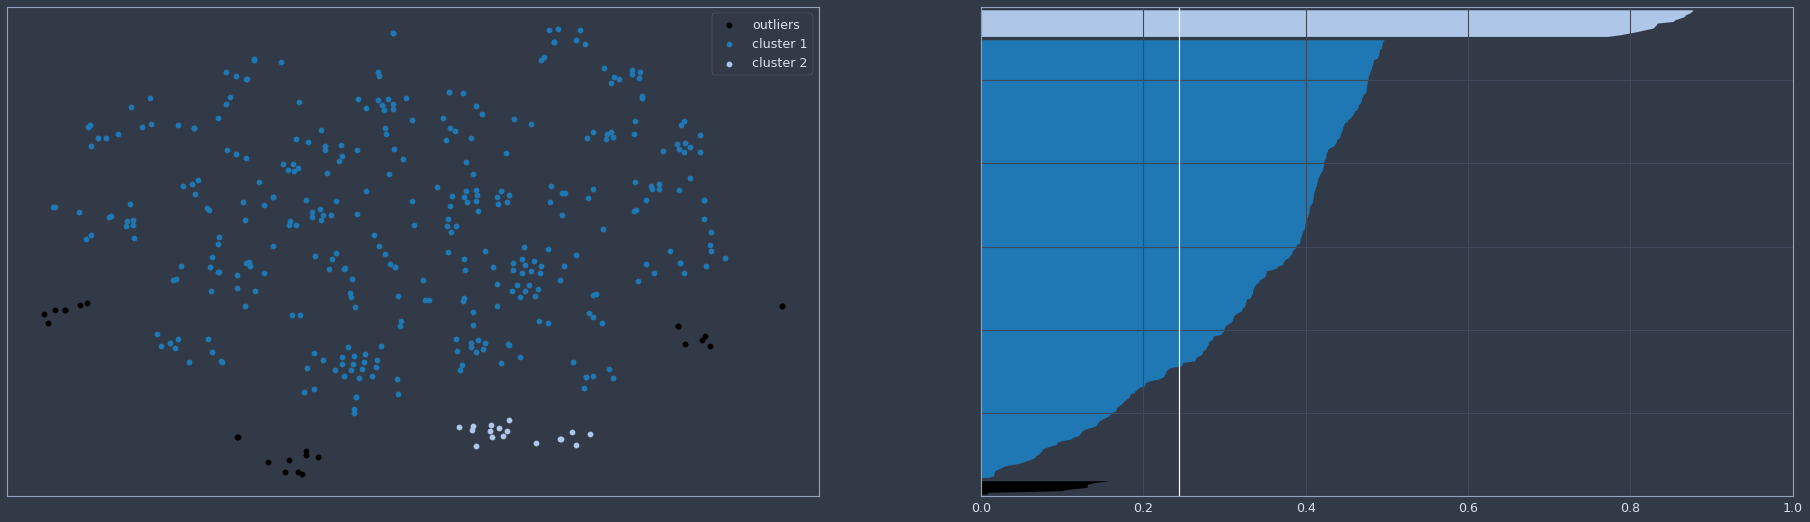

In [71]:
conts_fig

##### F-Test

###### Compute

In [72]:
contest_cs = sel_dc['continuous']+['context_cluster']
impsv_df = assign_clusters(imp_df,conclu_df,label,'dbscan')
conf_df,connull_df = f_pvalues(impsv_df[contest_cs],label,.05)
confstat_fig = fstat_fig(impsv_df,conf_df,label)
conf_df.head(10)

,p_value,f_stat
Q16552,0.000126,84.004844
P05112,0.000126,63.653184
P18627,0.000126,61.157445
Q99616,0.000126,56.803505
P01375,0.000126,52.830236
P80075,0.000126,52.236439
Q8IU57,0.000126,49.823174
Q14116,0.000126,49.735425
P06127,0.000126,47.771522
Q96PD2,0.000126,47.102021


###### Figure

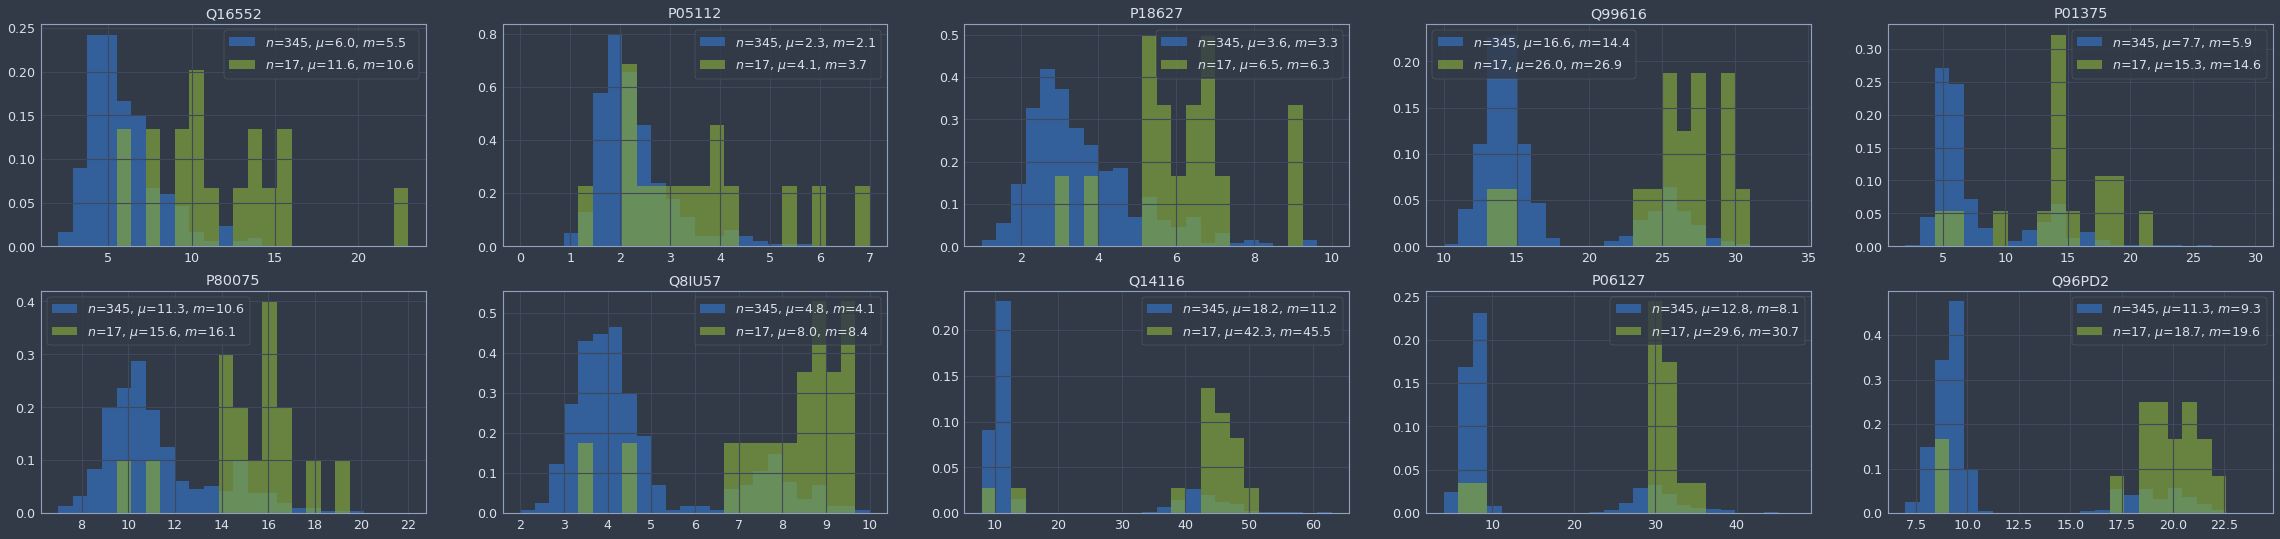

In [73]:
confstat_fig

#### Clinical View

##### Definition

###### Definition

In [74]:
cli_df = std_df[physio_cs+conpc_cs+infpc_cs].copy(deep=True)

###### Orthogonalization

In [75]:
cli_odf = ortho_project(cli_df,dem_df)

##### Clustering Optimization

###### Grid Search

In [76]:
label  = 'clinic'
cliopt_df = cluster_optimization(cli_odf,n_states,n_comps,epss,minss,label)
cliopt_df.head(3)

,dim,state,epsilon,n_mins,n_clusters,silhouette
1896,2,49,6.2,15,2,0.167779
1928,2,49,6.3,16,2,0.167279
1865,2,49,6.1,15,2,0.157744


###### Compute Silhouettes

In [77]:
clits_df,cliclu_df = optimal_clusters(cli_odf,cliopt_df)
clits_fig          = cluster_fig(clits_df,cliclu_df,'dbscan')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


###### Figure

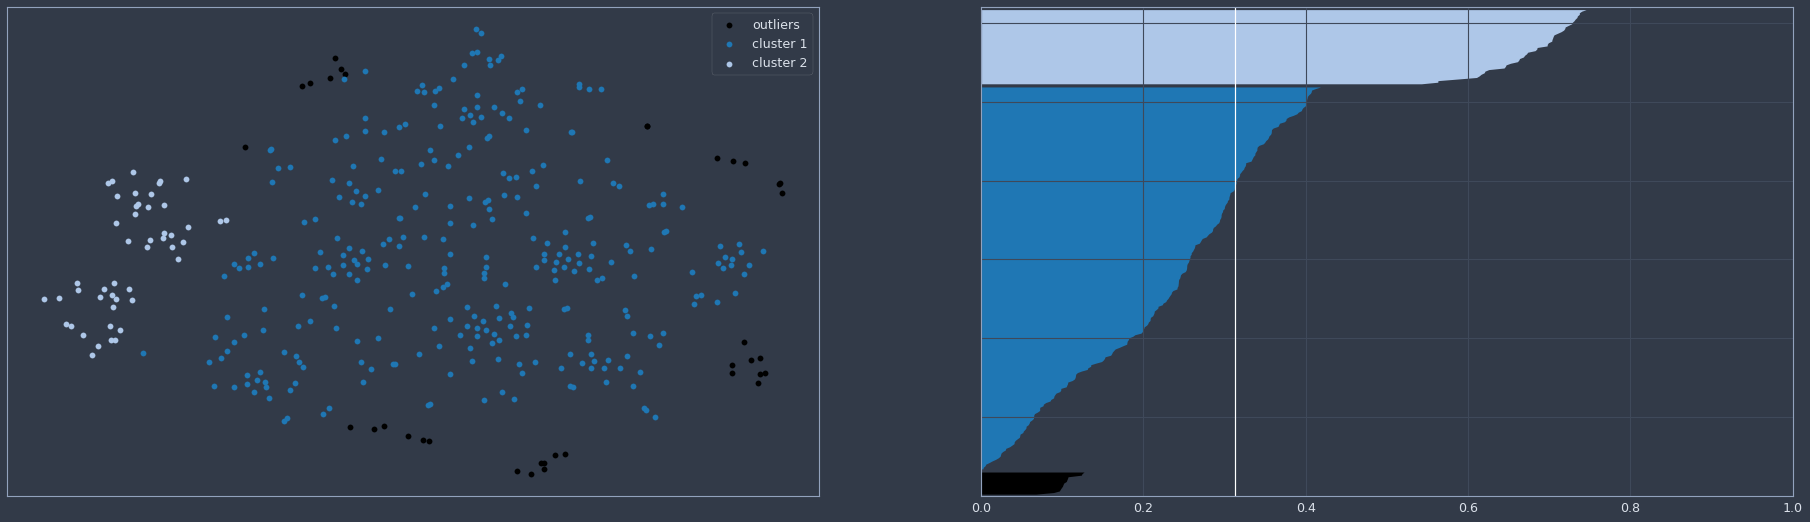

In [78]:
clits_fig

##### F-Test

###### Compute

In [88]:
contest_cs = sel_dc['continuous']+['clinic_cluster']
impsv_df = assign_clusters(imp_df,cliclu_df,label,'dbscan')
clif_df,clinull_df = f_pvalues(impsv_df[contest_cs],label,.05)
clifstat_fig = fstat_fig(impsv_df,clif_df,label)
clif_df.head(10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7938/7938 [02:00<00:00, 65.64it/s]


,p_value,f_stat
Q8WTU2,0.000126,79.289812
P28845,0.000126,66.953128
Q8IZP9,0.000126,65.084774
P16278,0.000126,61.994206
P22466,0.000126,51.347049
P19022,0.000126,46.877219
Q03426,0.000126,43.864501
Q13308,0.000126,43.365339
Q02246,0.000126,43.262240
sbp.low,0.000126,42.705087


###### Figure

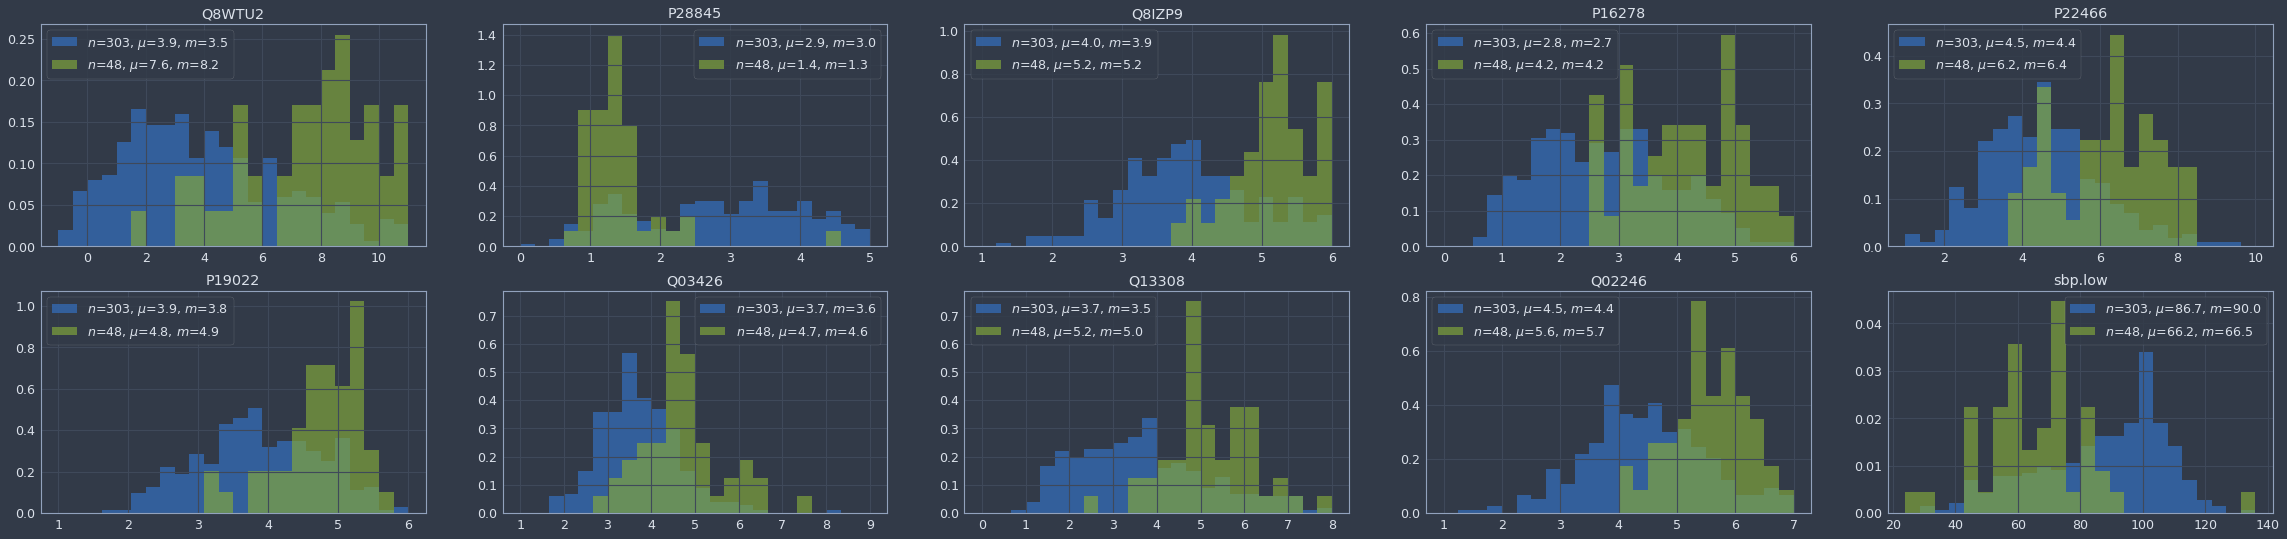

In [89]:
clifstat_fig

#### Proteomic View

##### Definition

###### Definition

In [90]:
pro_df = std_df[protein_cs].copy(deep=True)

###### Orthogonalization

In [91]:
pro_odf = ortho_project(pro_df,dem_df)

##### Clustering Optimization

###### Grid Search

In [92]:
label  = 'protein'
proopt_df = cluster_optimization(pro_odf,n_states,n_comps,epss,minss,label)
proopt_df.head(3)

,dim,state,epsilon,n_mins,n_clusters,silhouette
1814,2,42,5.9,26,3,0.595383
1676,2,42,5.5,12,3,0.595383
1838,2,42,6.0,19,3,0.595383


###### Compute Silhouettes

In [93]:
prots_df,proclu_df = optimal_clusters(pro_odf,proopt_df)
prots_fig          = cluster_fig(prots_df,proclu_df,'dbscan')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


###### Figure

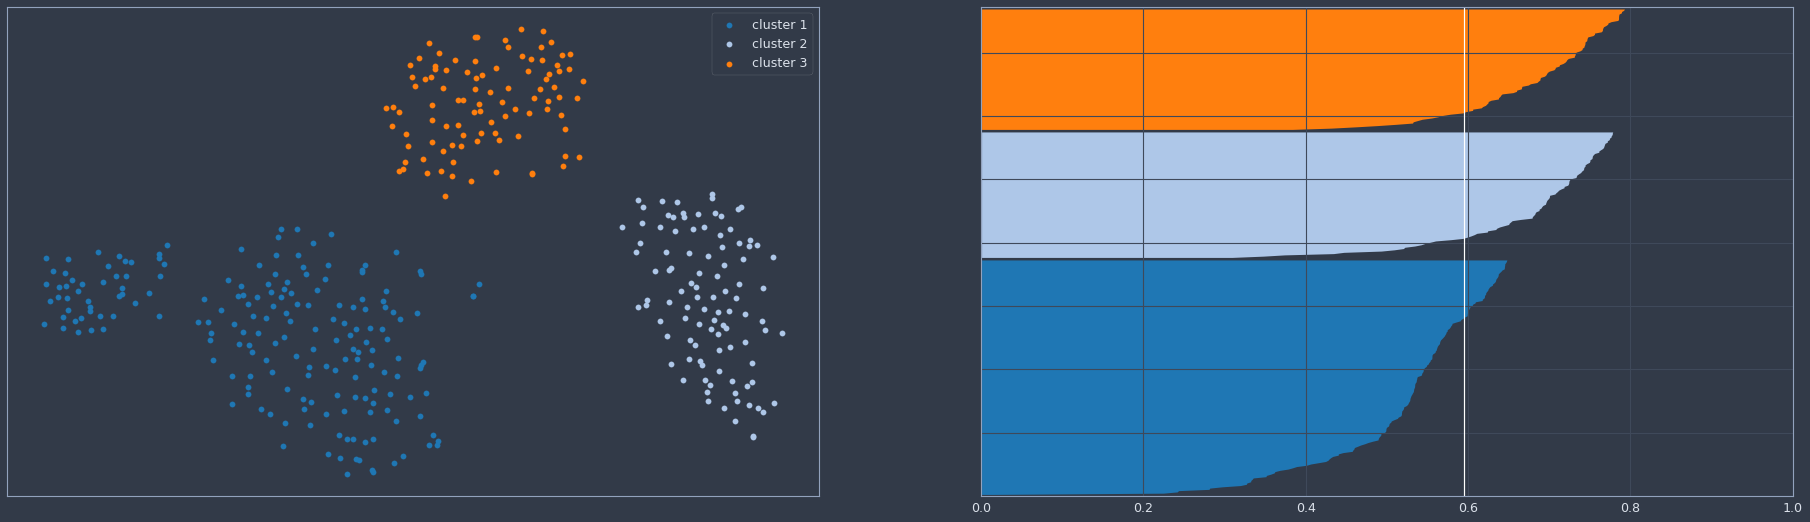

In [94]:
prots_fig

##### Hierarchical Clustering

###### Compute

In [99]:
prohie_fig,prohie_df = hierarchical_cluster(prots_df,4)
prohie_fig2          = cluster_fig(prots_df,prohie_df,'hieclu')

###### Figure

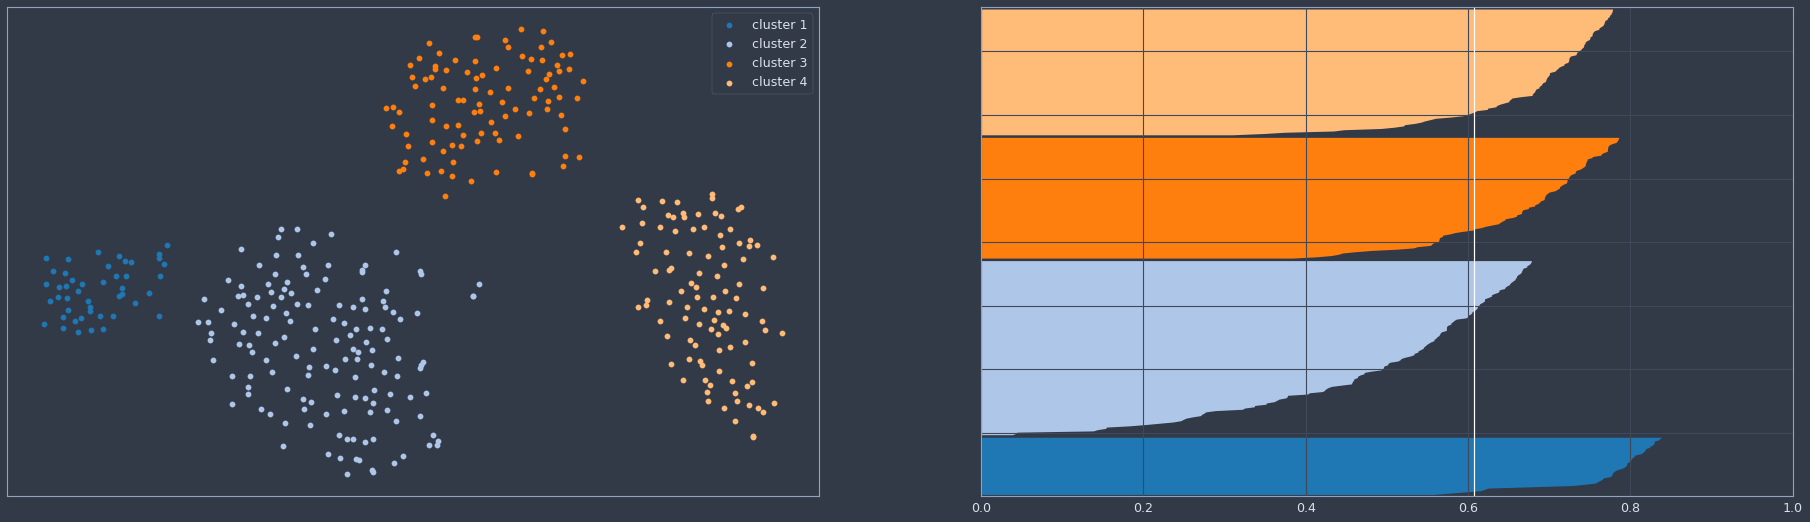

In [100]:
prohie_fig2

##### F-Test

###### Compute

In [103]:
contest_cs = sel_dc['continuous']+['protein_cluster']
impsv_df = assign_clusters(imp_df,prohie_df,label,'hieclu')
prof_df,pronull_df = f_pvalues(impsv_df,label,.05)
profstat_fig = fstat_fig(impsv_df,prof_df,label)
prof_df.head(10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9578/9578 [03:21<00:00, 47.64it/s]


,p_value,f_stat
P09603,0.000104,60487.173473
P52823,0.000104,4802.617777
P29460,0.000104,4768.470803
Q14116,0.000104,4222.576944
P80162,0.000104,3682.849781
P15692,0.000104,3378.481422
P06127,0.000104,3324.827568
Q96PD2,0.000104,2991.195137
P50591,0.000104,2722.204994
P48740,0.000104,2371.935262


###### Figure

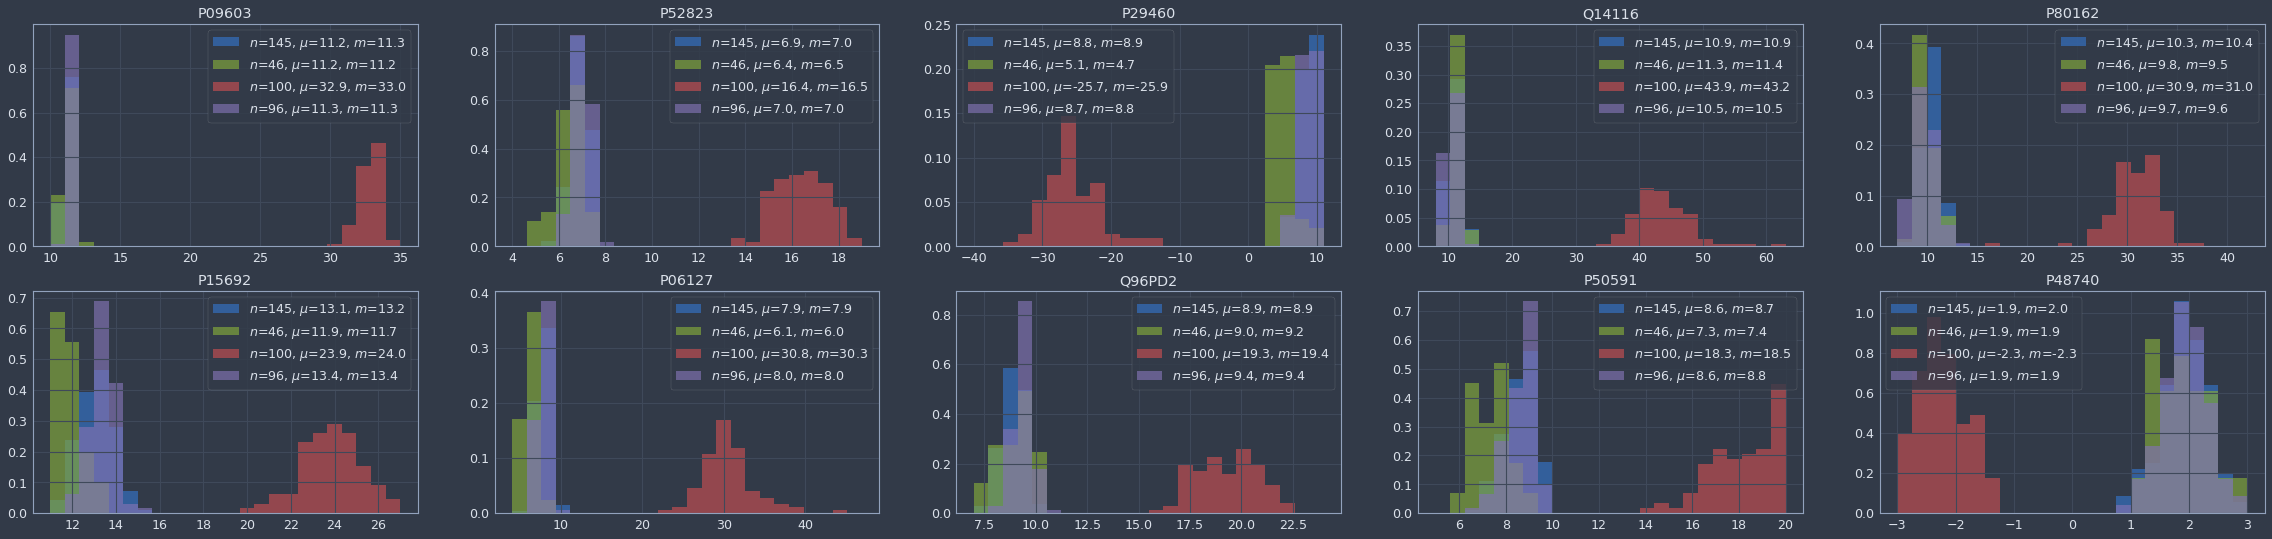

In [104]:
profstat_fig

### Multi-View Clustering

### Gene Ontology Term Enrichment

### Biomarker Search